# 0.0 Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import random

from IPython.core.display  import HTML
from IPython.display       import Image

from colorama                import Fore, Back, Style

# 1.0 Helper Functions

In [24]:
def jupyter_settings():
    %matplotlib inline

    color_pal = sns.color_palette()
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

    sns.set()
jupyter_settings()

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Create function to calculate percentage of values and plot the results
def plot_features(df, column, target):
    table_perc = df.groupby(target)[column].value_counts(normalize = True, sort = False) * 100
    table_perc = table_perc.reset_index(name="percentage")
    
    sns.barplot(x = column, y = 'percentage', hue = target, data = table_perc, palette = 'hls')
    labels = [i for i in range(0,105,5)]
    plt.yticks(labels)
    plt.ylabel('% ')
    return plt.show()

# 2.0 Data Reading

In [3]:
# # df = pd.read_csv('Dataset_model.csv')
df = pd.read_csv('data/train.csv')
sub = pd.read_csv('data/sample_submission.csv')
test = pd.read_csv('data/test.csv')

print(df.shape, test.shape, sub.shape)

(9500, 17) (3000, 16) (3000, 2)


# 3.0 EDA

## Descriptive Float Cols Stats

In [21]:
df.describe()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros
count,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000,9500.00000
mean,6210.53295,126.39842,404.53203,1437.08642,195037.27423,611.99932,32.27082,10.86368,17.55232,21.43316,20.99032,29.83242,24.93716,66.61863
std,3603.24391,685.03600,217.69673,1156.26322,1454273.73229,2002.44388,5.10605,62.55542,120.98019,122.67739,14.80061,222.63776,183.73335,440.11852
min,1.00000,18.00000,0.08863,0.23000,10473.86535,0.00000,20.99291,0.00000,0.00000,1.00000,-5.00000,0.00000,0.00000,1.00000
25%,3091.75000,28.00000,272.36306,573.62000,26207.90039,76.08398,28.07887,2.00000,3.00000,4.00000,10.00000,9.00000,2.00000,8.00000
50%,6172.50000,38.00000,337.16959,1175.73000,45991.10600,134.20148,32.26265,3.00000,6.00000,6.00000,18.00000,14.00000,4.00000,14.00000
75%,9320.25000,47.00000,471.26466,1963.33250,80449.82925,249.18291,36.46458,6.00000,7.00000,7.00000,28.00000,18.00000,8.00000,20.00000
max,12500.00000,8598.00000,1602.04052,4998.07000,23279657.97600,10000.00000,49.56452,1496.00000,1779.00000,1479.00000,67.00000,4388.00000,2589.00000,5788.00000


In [26]:
numerical_cols = [col for col in df.columns if df[col].dtype == 'float64']
int_cols = [col for col in df.columns if df[col].dtype == 'int64' and col not in ('id_cliente')]

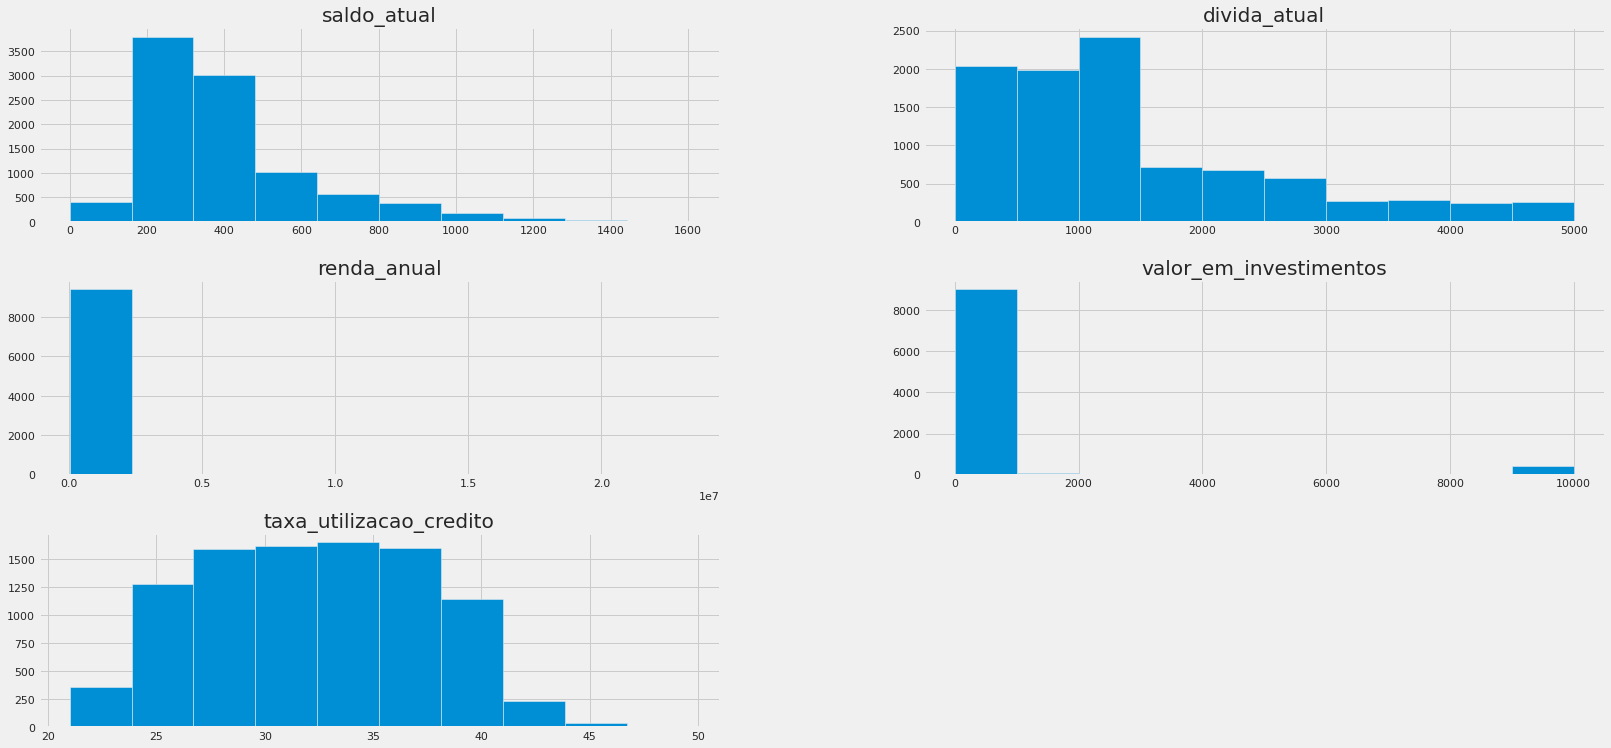

In [28]:
df[numerical_cols].hist();

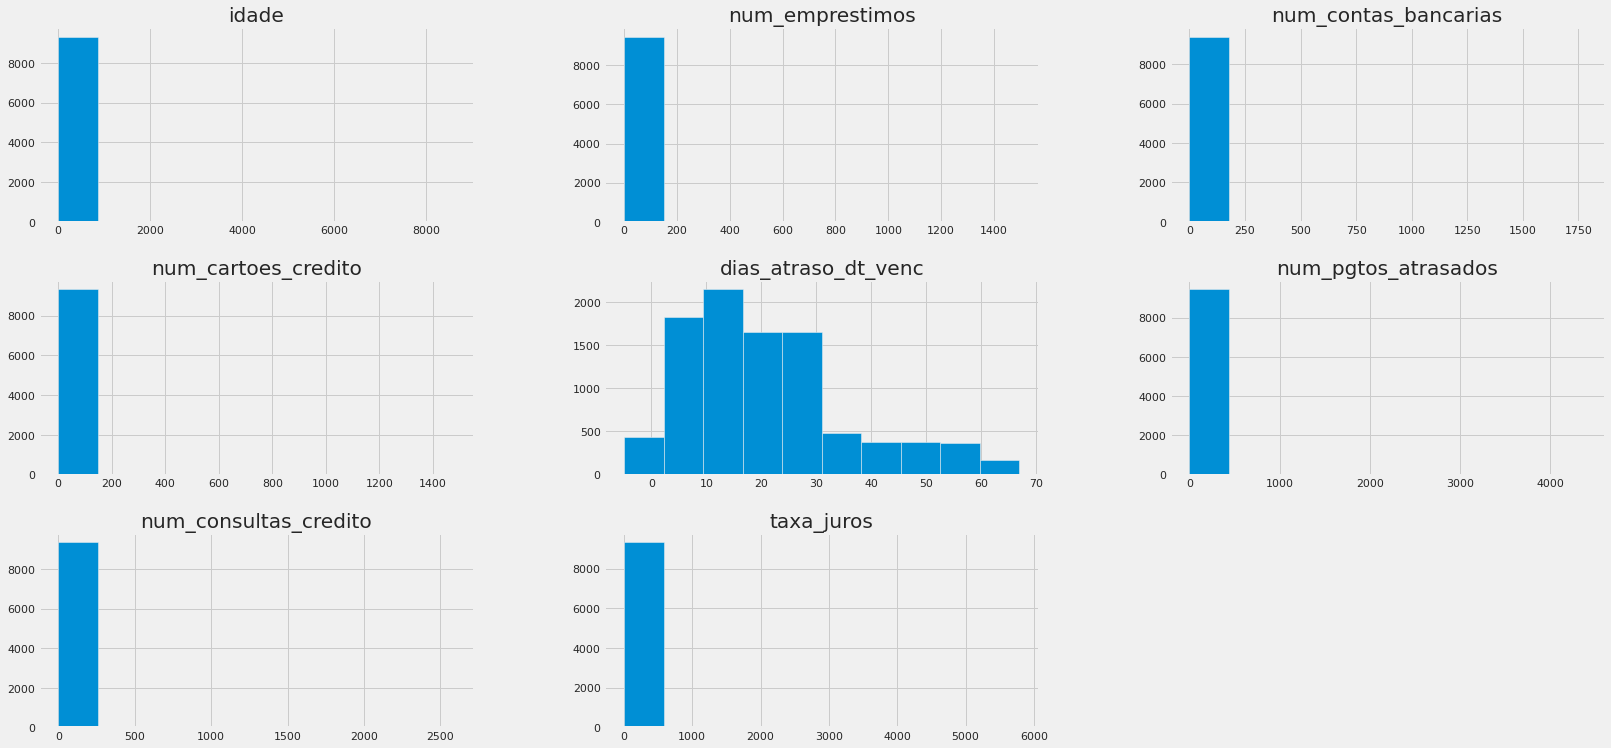

In [29]:
df[int_cols].hist();

We can see that some features have strange histograms, as if they were binary features or have a huge concentration in one  value. We need to zoom in to check them out.

### Distribution of 'Renda Anual'

Let's check our first feature with a strange histogram, "renda_anual".

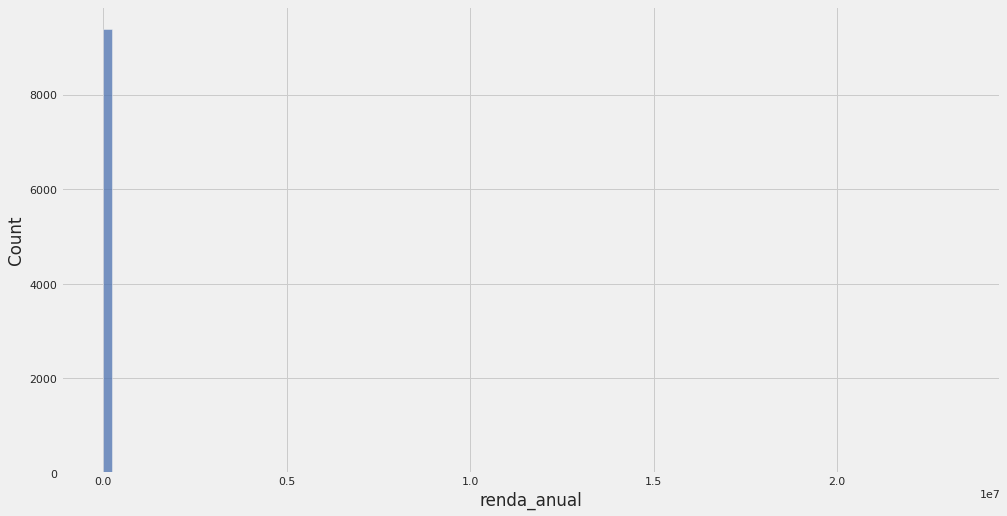

In [36]:
plt.figure(figsize=(15, 8))
sns.histplot(df.renda_anual, bins=100,kde=False)
plt.show()

If we zoom in the spike, we see that there are many values between 0 and 0.1e6 (100_000). It is something similar to what happens in [American Express Competition](aggle.com/competitions/amex-default-prediction), where random noise were injected.

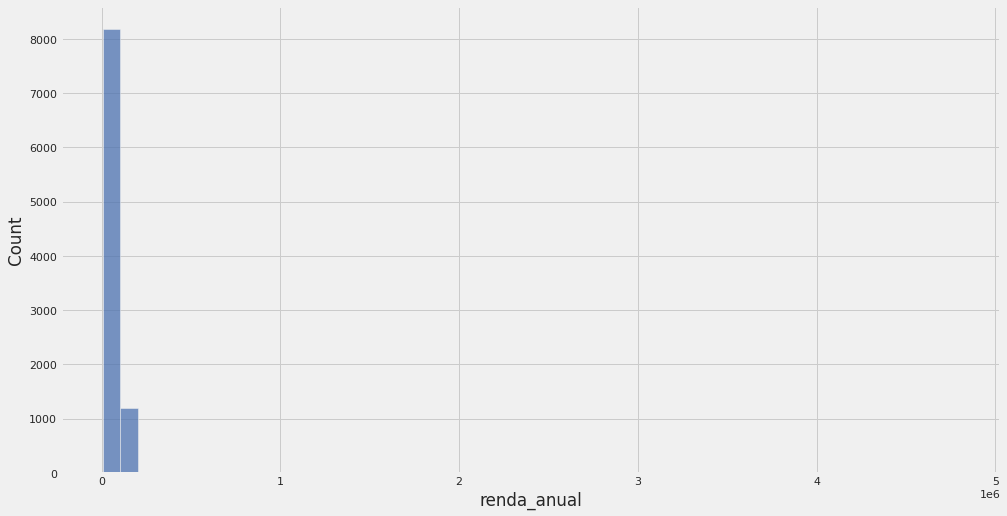

In [37]:
plt.figure(figsize=(15, 8))
sns.histplot(df.loc[df.renda_anual<0.5e7,'renda_anual'], bins=50,kde=False)
plt.show()

If we clip the mean of the distribution, we observe a different shape above and below it.

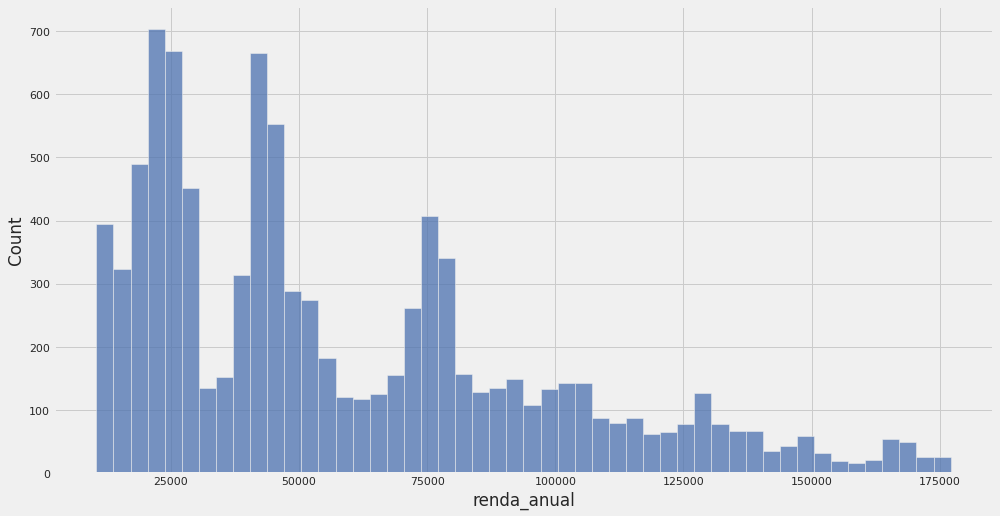

In [56]:
plt.figure(figsize=(15, 8))
sns.histplot(df.loc[(df.renda_anual < df.renda_anual.mean()),'renda_anual'], bins=50,kde=False)
plt.show()

<Figure size 864x720 with 0 Axes>

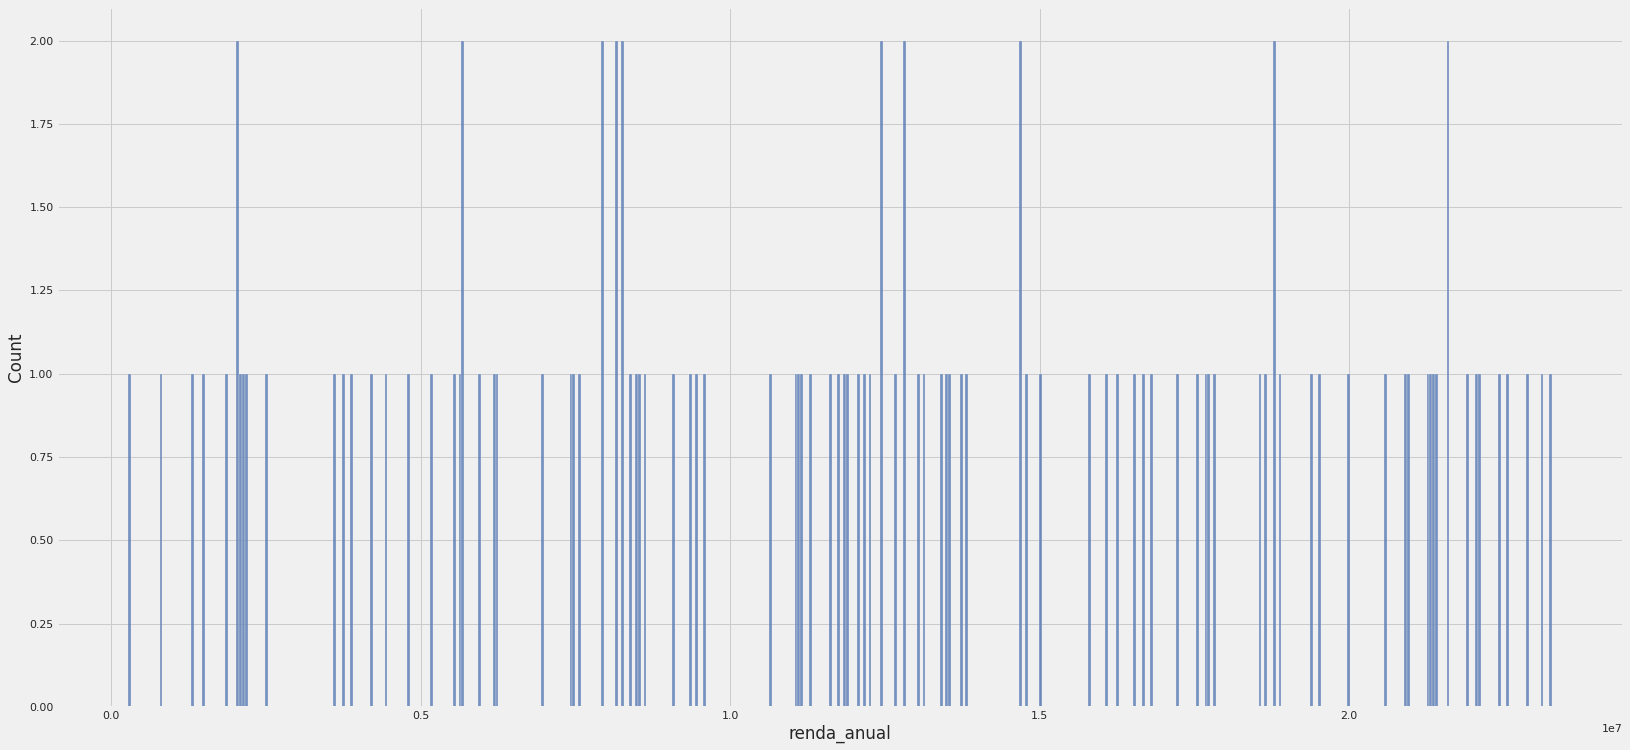

In [57]:
plt.figure(figsize=(12, 10))
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
ax = sns.histplot(df.loc[(df.renda_anual > df.renda_anual.mean()),'renda_anual'], bins=500,kde=False)
plt.show()

### Distribution of 'Valor_em_investimentos'

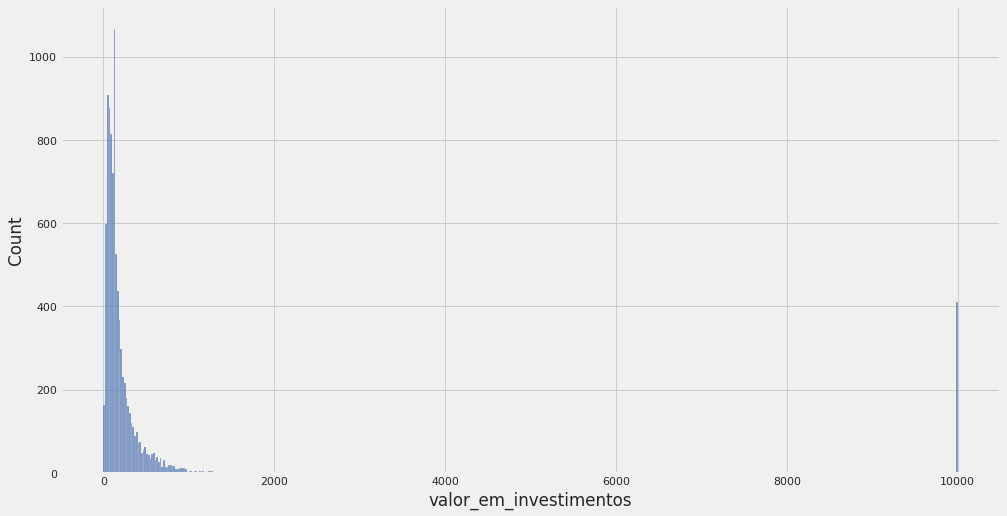

In [69]:
plt.figure(figsize=(15, 8))
sns.histplot(df.valor_em_investimentos, bins=500,kde=False)
plt.show()

<Figure size 1080x720 with 0 Axes>

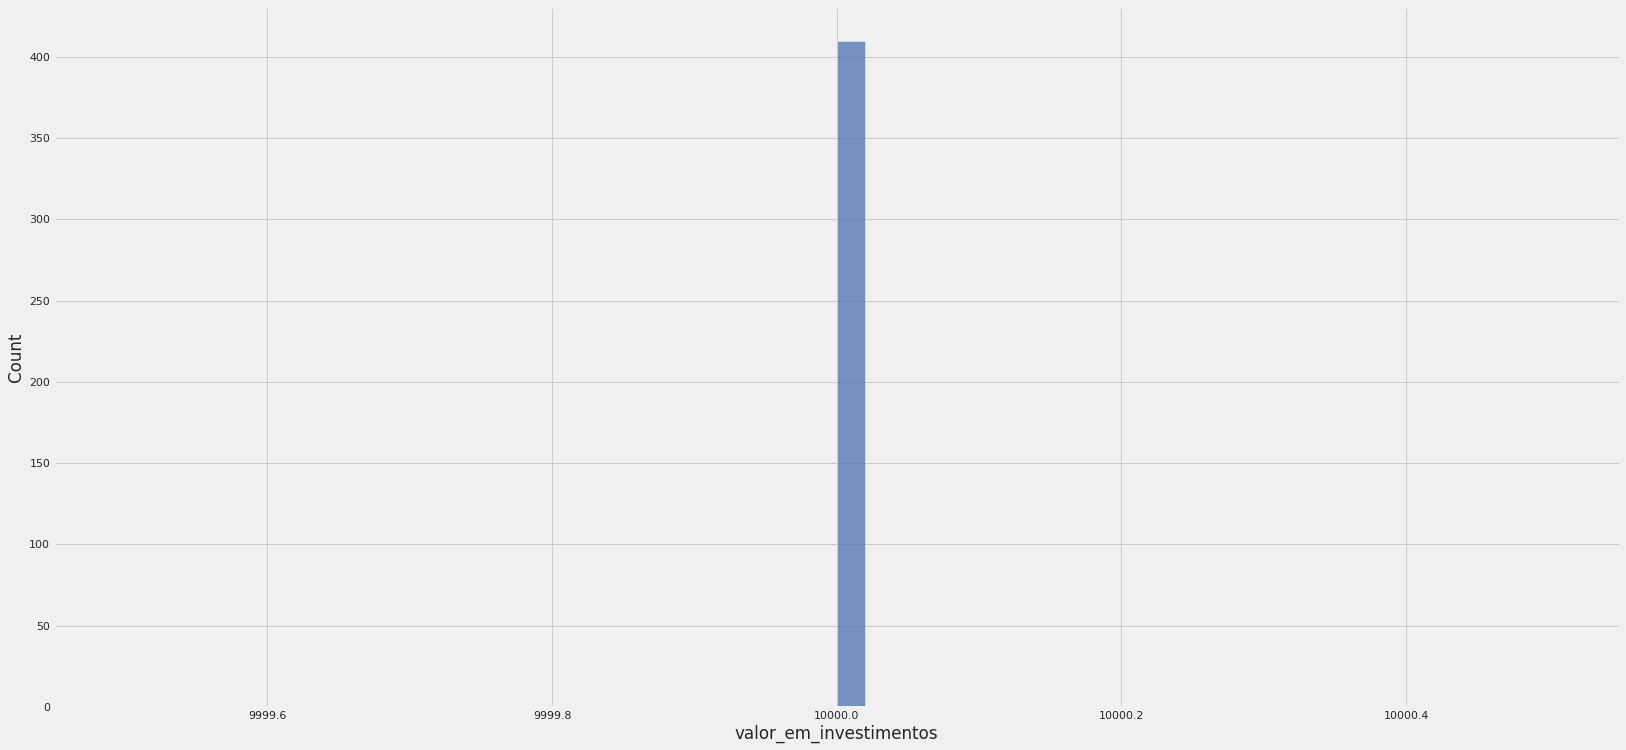

In [73]:
plt.figure(figsize=(15, 10))
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
ax = sns.histplot(df.loc[df.valor_em_investimentos == 10_000,'valor_em_investimentos'], bins=50,kde=False)
plt.show()

In [74]:
df.loc[df.valor_em_investimentos == 10_000, 'valor_em_investimentos'].shape

(410,)

We have 410 values of '10_000'! Probably randomly injected. 

In [82]:
aux_vei = df.loc[df.valor_em_investimentos != 10_000]

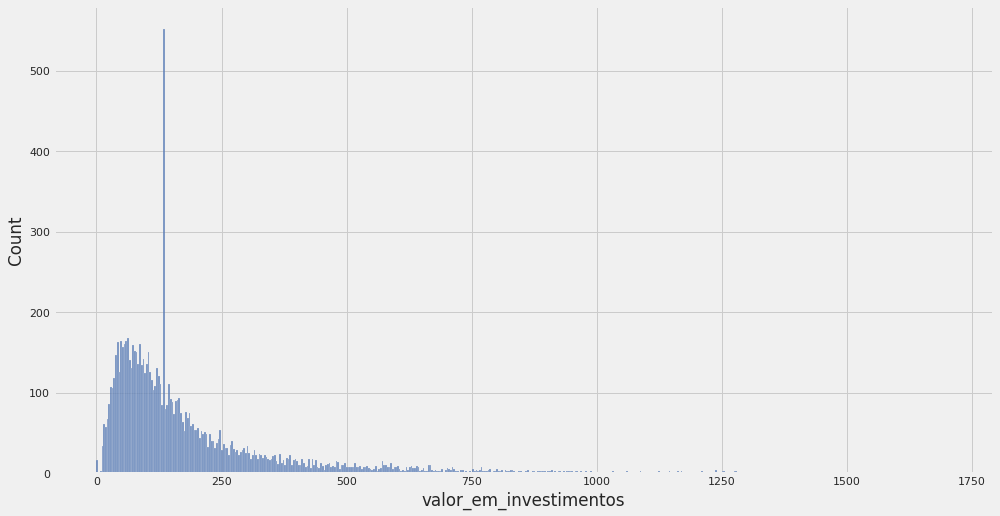

In [83]:
plt.figure(figsize=(15, 8))
sns.histplot(aux_vei.valor_em_investimentos, bins=500,kde=False)
plt.show()

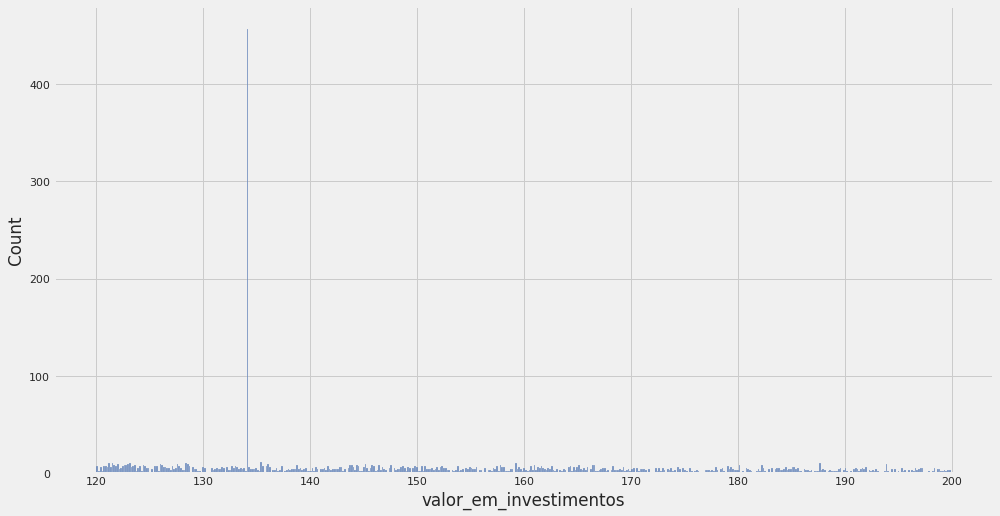

In [84]:
plt.figure(figsize=(15, 8))
sns.histplot(aux_vei.loc[(aux_vei.valor_em_investimentos > 120) & (aux_vei.valor_em_investimentos < 200), 'valor_em_investimentos'], bins=500,kde=False)
plt.show()

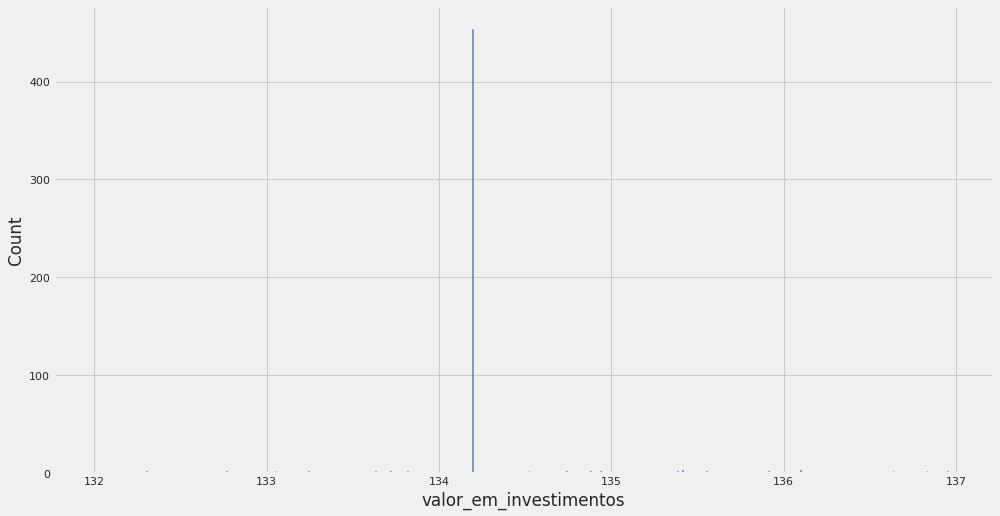

In [85]:
plt.figure(figsize=(15, 8))
sns.histplot(aux_vei.loc[(aux_vei.valor_em_investimentos > 132) & (aux_vei.valor_em_investimentos < 137), 'valor_em_investimentos'], bins=500,kde=False)
plt.show()

## Descriptive Integer Cols Stats

Since `int columns` are discrete numbers, it's easier to restrict them later in outlier treatment.

### NUM_EMPRESTIMOS

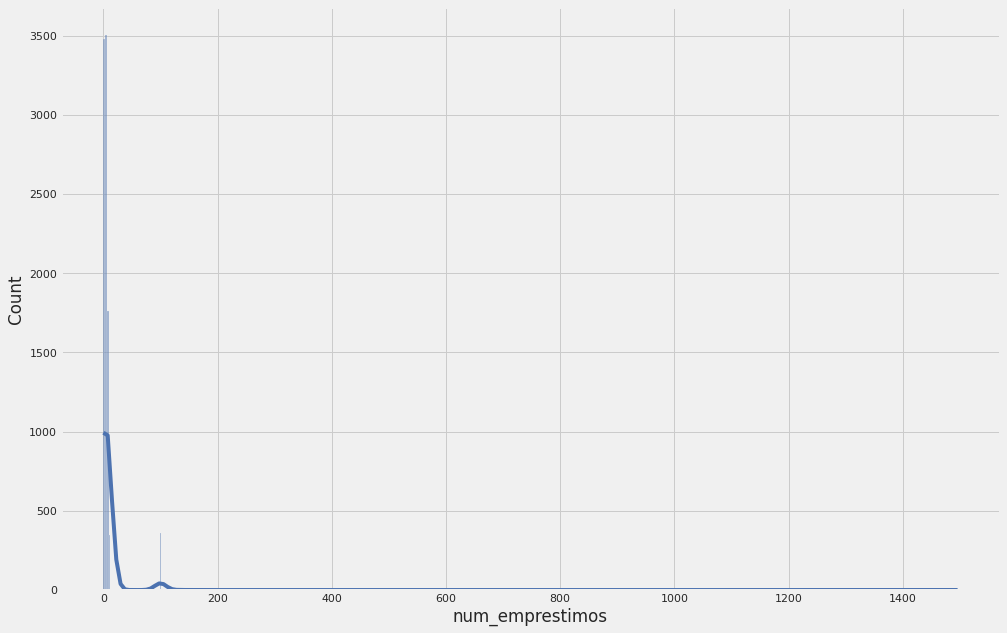

In [90]:
plt.figure(figsize=(15, 10))
sns.histplot(df['num_emprestimos'], bins=500, kde=True);

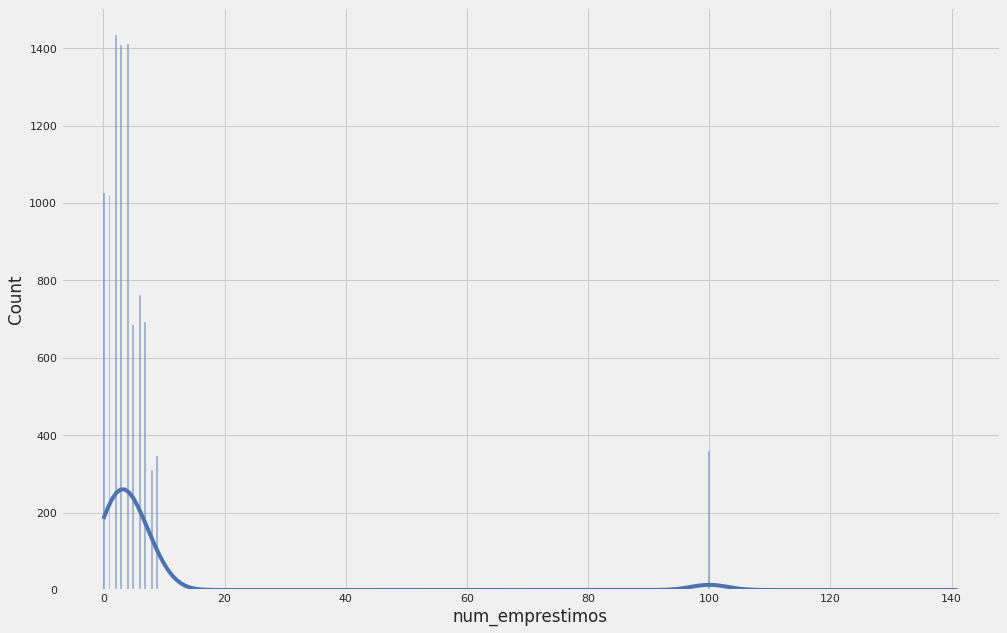

In [91]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['num_emprestimos']< 200, 'num_emprestimos'], bins=500, kde=True);

In [94]:
df.loc[df['num_emprestimos'] != 100, 'num_emprestimos'].shape

(9140,)

In [99]:
df.loc[df['num_emprestimos'] < 100, 'num_emprestimos'].shape

(9095,)

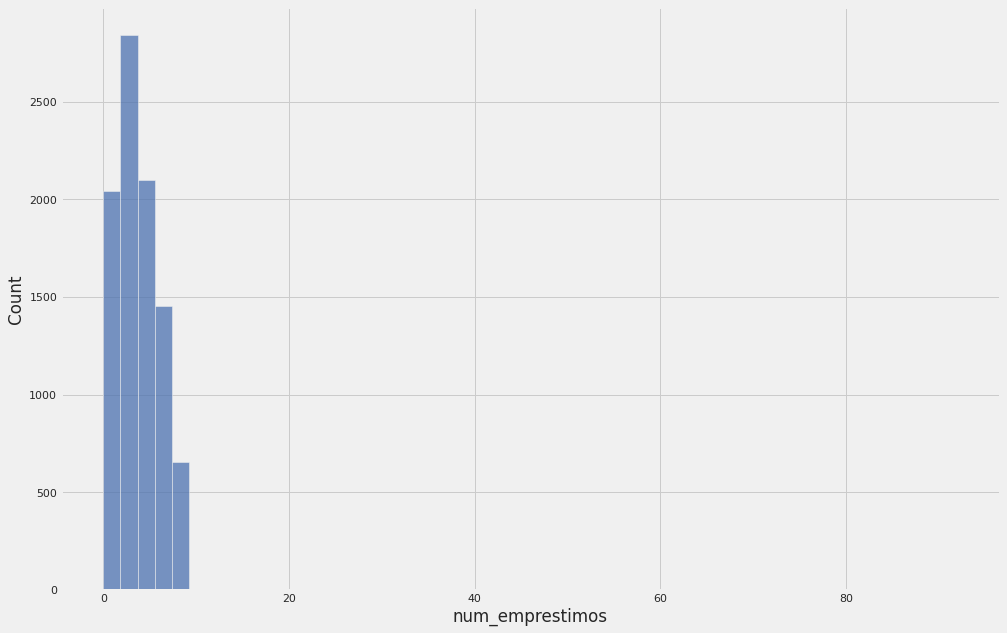

In [100]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['num_emprestimos'] < 100, 'num_emprestimos'], bins=50, kde=False);

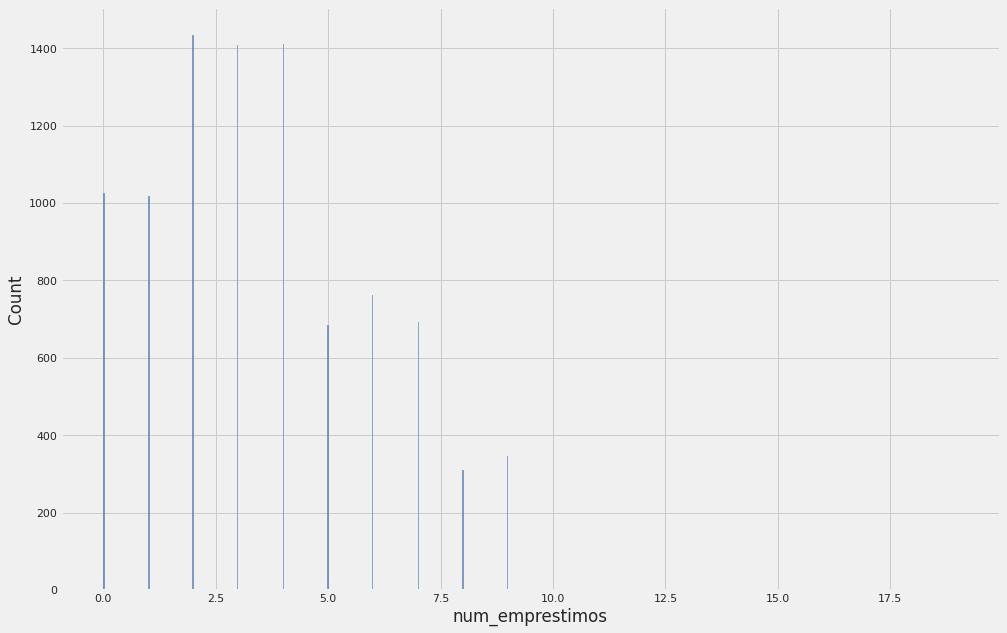

In [102]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[(df['num_emprestimos'] < 20), 'num_emprestimos'], bins=500, kde=False);

In [95]:
df.loc[(df['num_emprestimos'] < 100 , 'num_emprestimos')].median()

3.0

### NUM_CONTAS_BANCARIAS

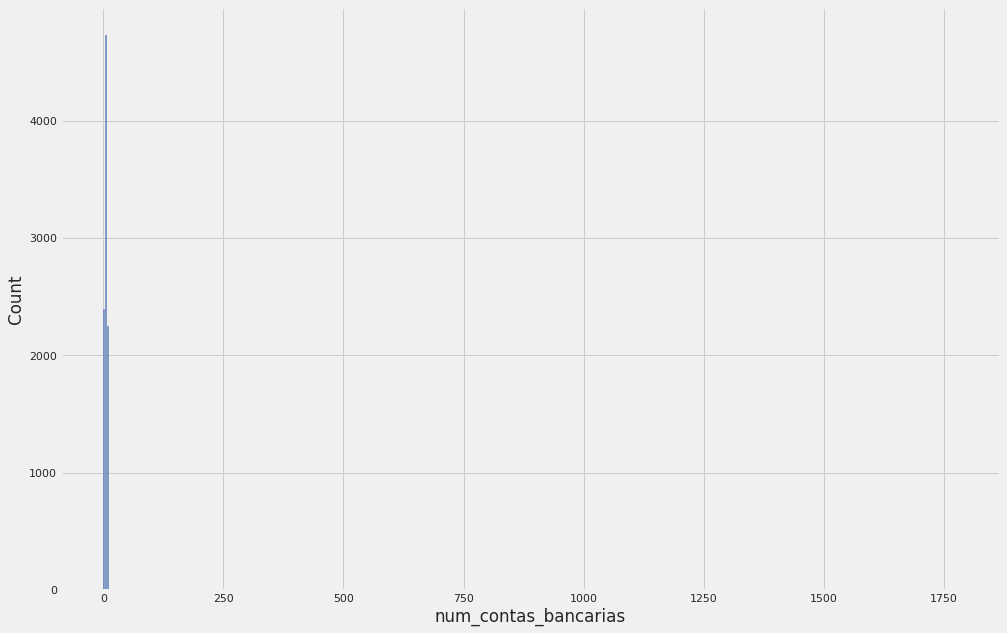

In [103]:
plt.figure(figsize=(15, 10))
sns.histplot(df['num_contas_bancarias'], bins=500, kde=False);

In [104]:
df.loc[(df['num_contas_bancarias'] > 9) & (df['num_contas_bancarias'] < 11), 'num_contas_bancarias'].shape

(503,)

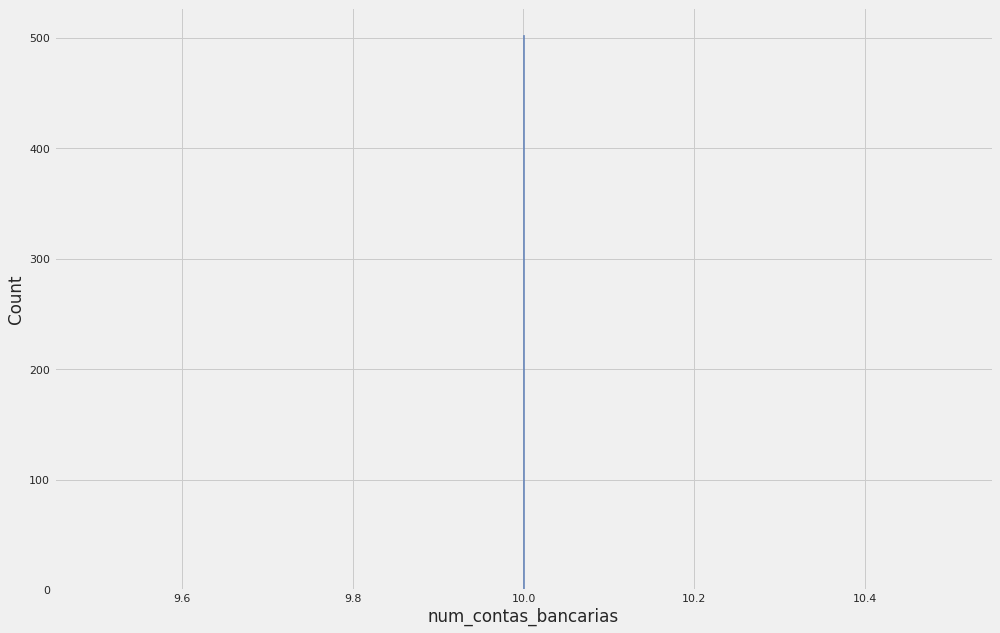

In [111]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['num_contas_bancarias'] == 10, 'num_contas_bancarias'], bins=500, kde=False);

In [508]:
df.loc[df['num_contas_bancarias'] < 11, 'num_contas_bancarias'].median()

6.0

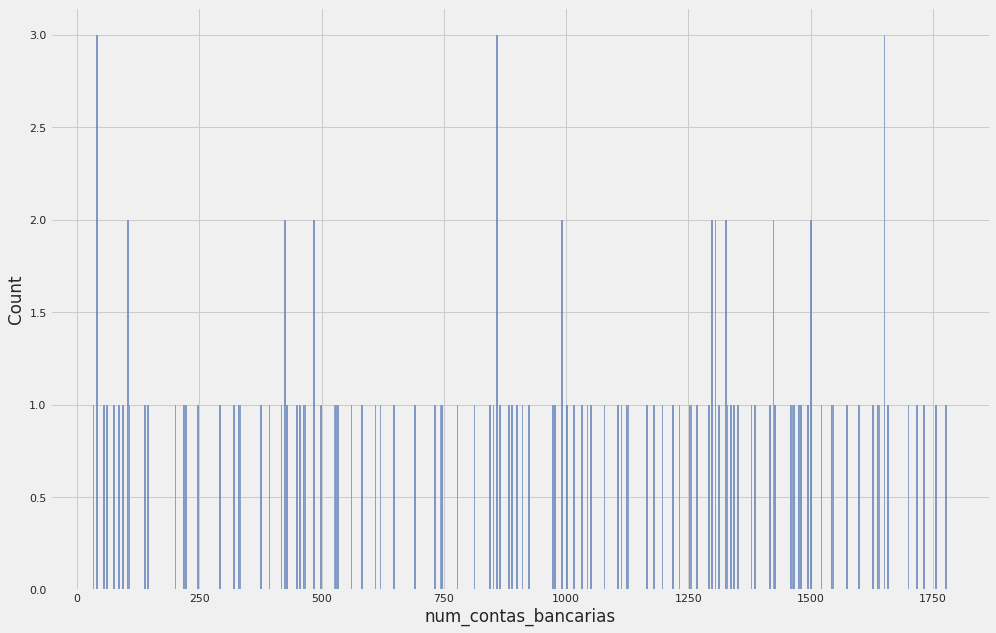

In [110]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['num_contas_bancarias'] > 10, 'num_contas_bancarias'], bins=500, kde=False);

### NUM_CARTOES_CREDITO

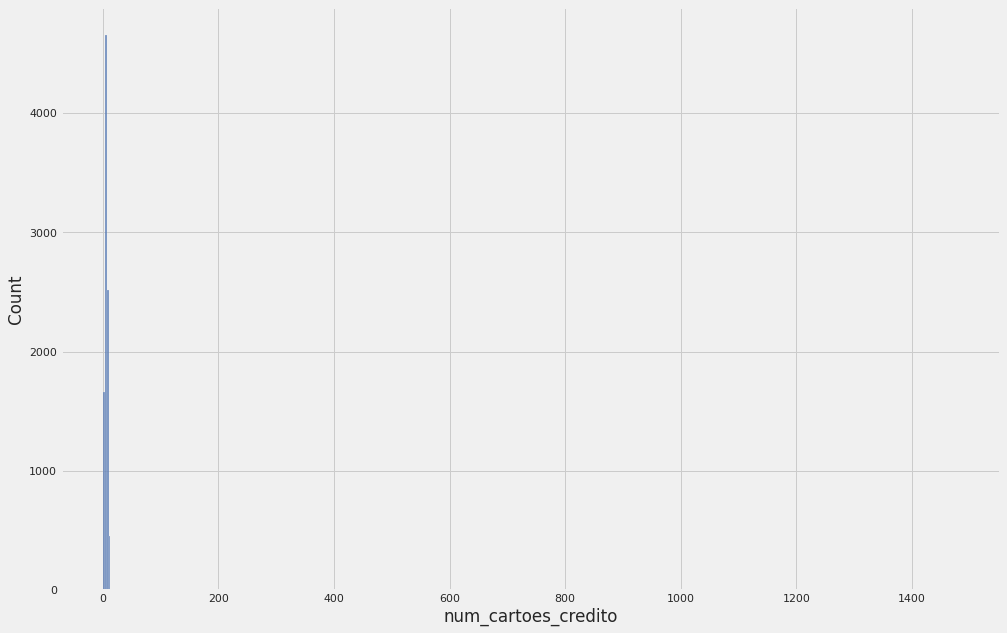

In [107]:
plt.figure(figsize=(15, 10))
sns.histplot(df['num_cartoes_credito'], bins=500, kde=False);

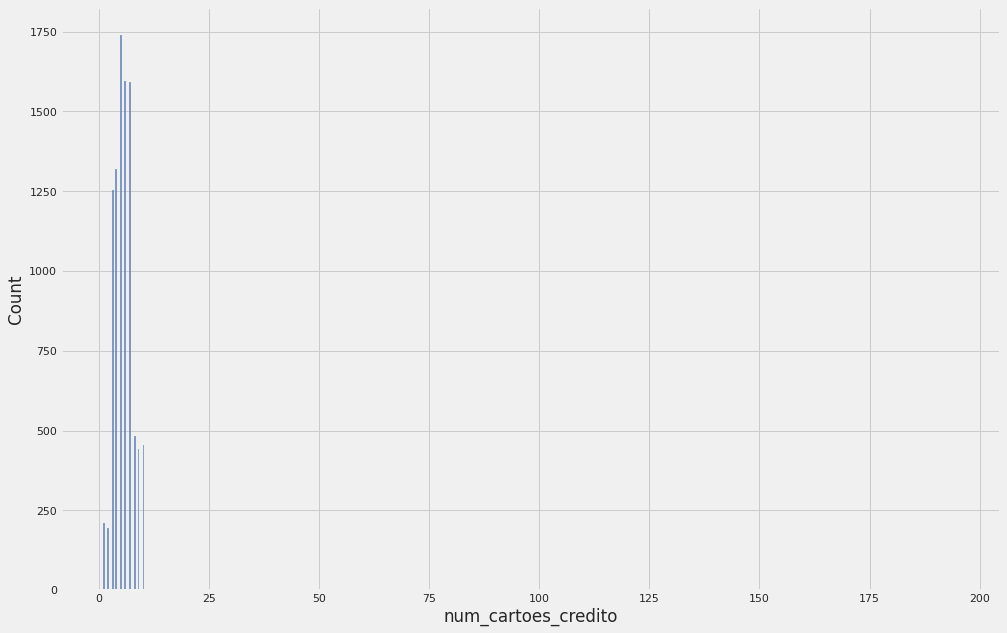

In [106]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['num_cartoes_credito'] < 200, 'num_cartoes_credito'], bins=500, kde=False);

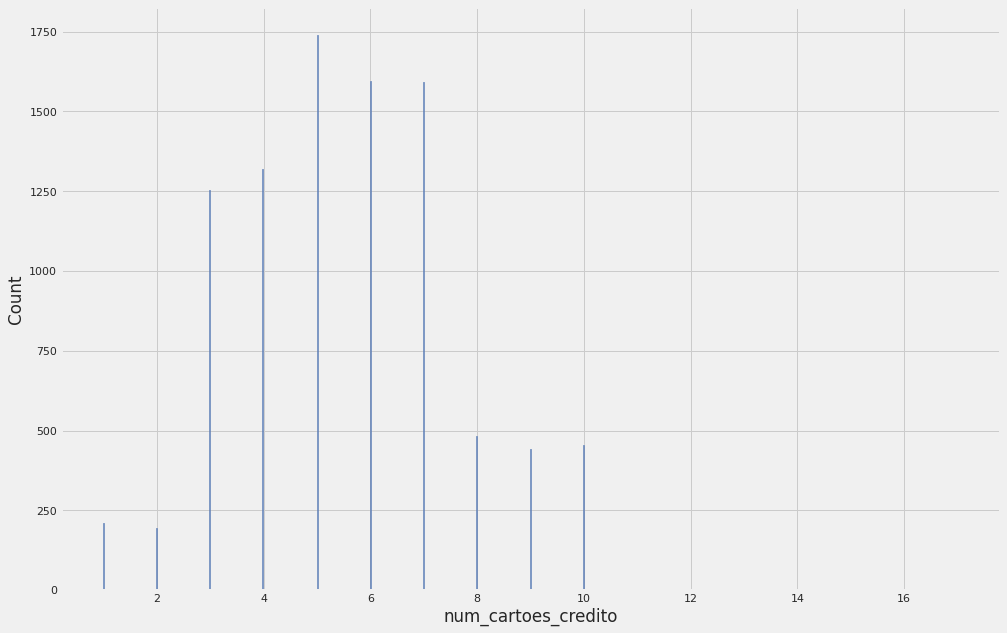

In [109]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['num_cartoes_credito'] < 25, 'num_cartoes_credito'], bins=500, kde=False);

In [509]:
df.loc[df['num_cartoes_credito'] < 11, 'num_cartoes_credito'].median()

5.0

### NUM_PGTOS_ATRASADOS

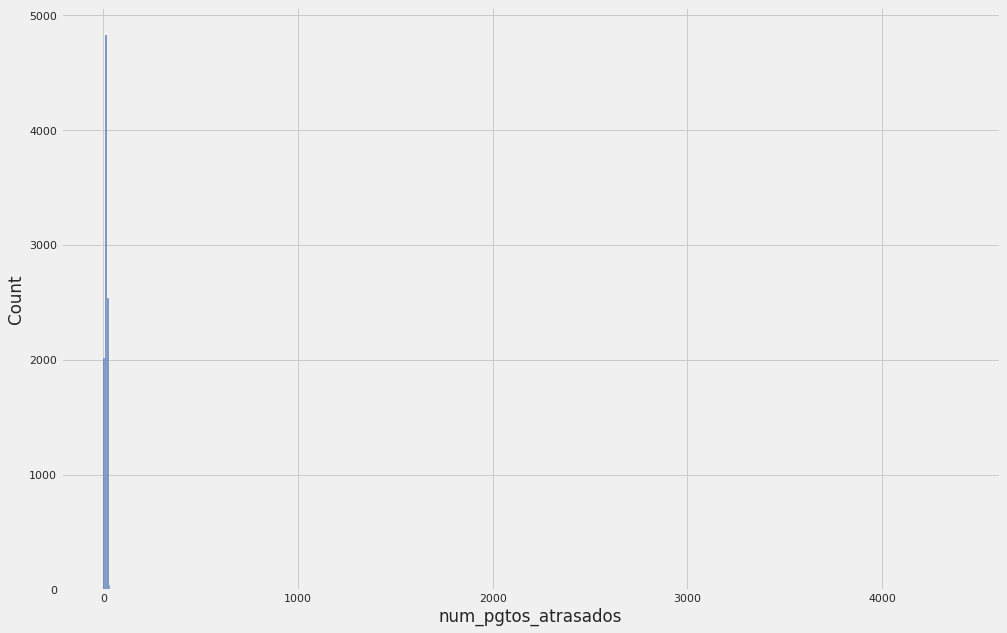

In [108]:
plt.figure(figsize=(15, 10))
sns.histplot(df['num_pgtos_atrasados'], bins=500, kde=False);

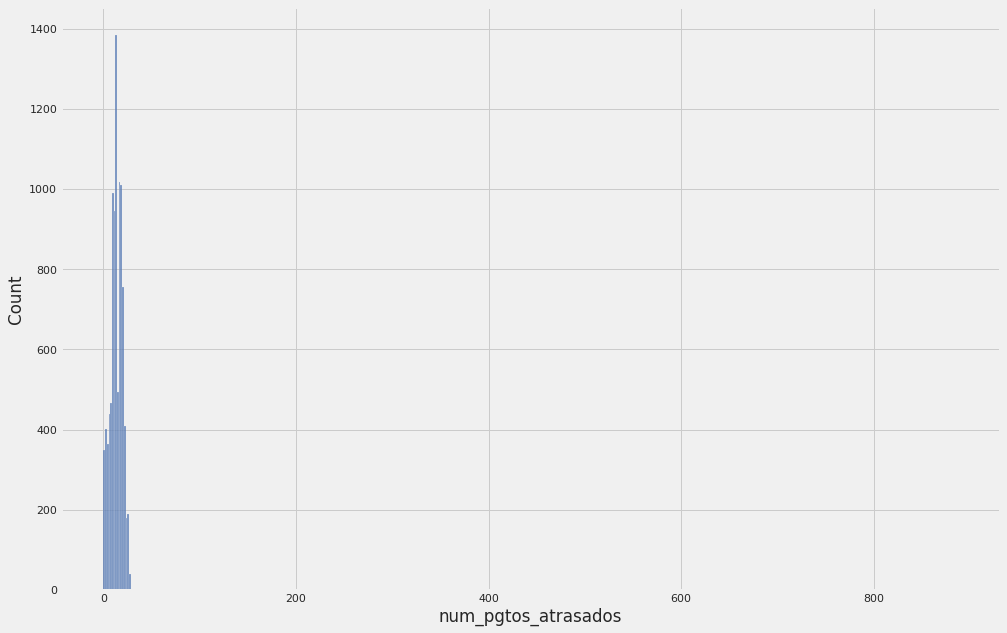

In [112]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['num_pgtos_atrasados'] < 1000, 'num_pgtos_atrasados'], bins=500, kde=False);

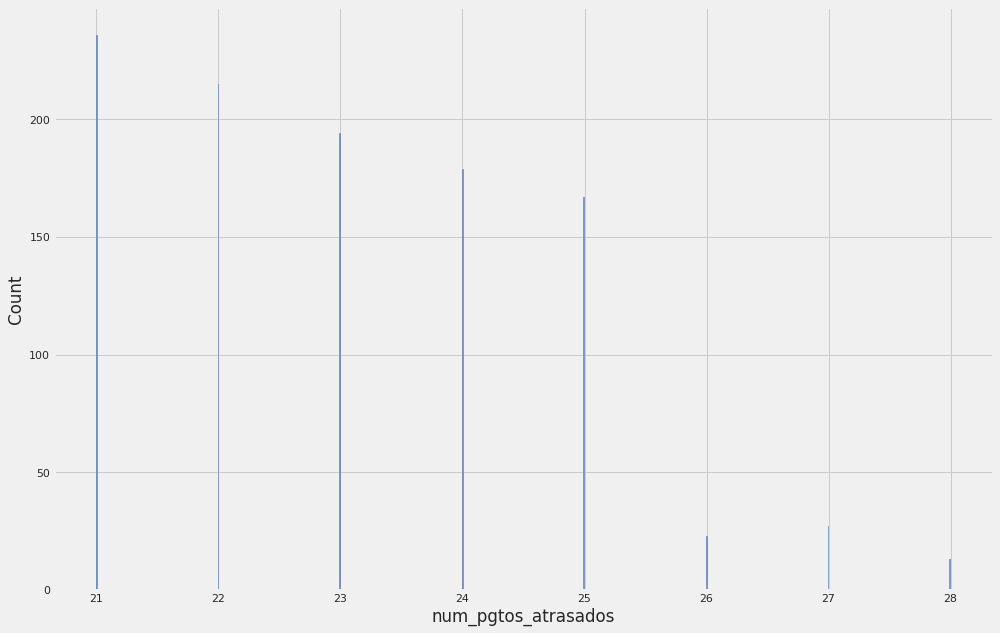

In [113]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[(df['num_pgtos_atrasados'] > 20) & (df['num_pgtos_atrasados'] < 40), 'num_pgtos_atrasados'], bins=500, kde=False);

In [116]:
df.loc[df['num_pgtos_atrasados'] <= 28, 'num_pgtos_atrasados'].median()

14.0

### NUM_CONSULTAS_CREDITO

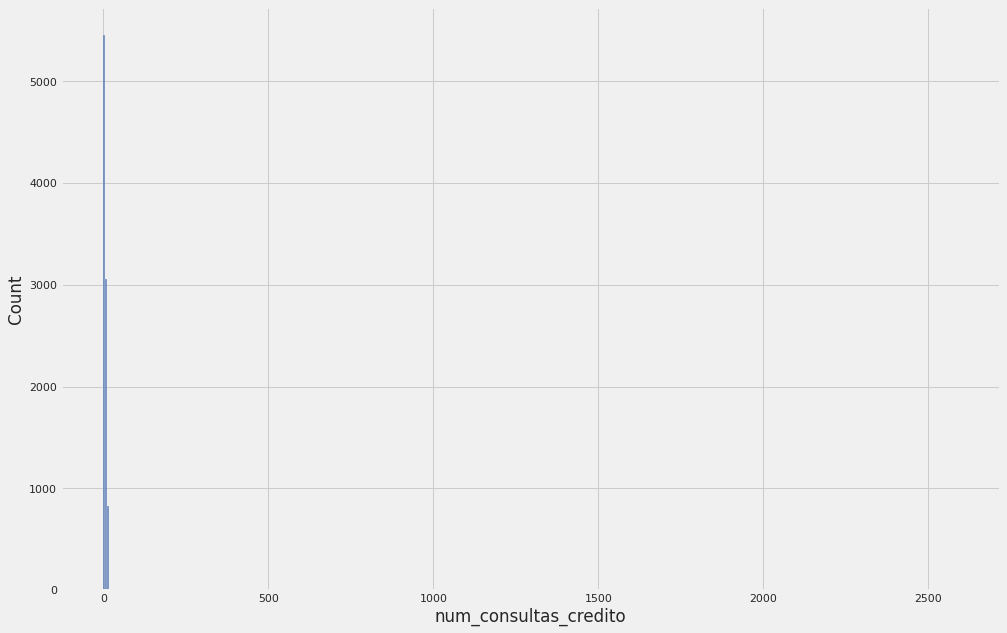

In [117]:
plt.figure(figsize=(15, 10))
sns.histplot(df['num_consultas_credito'], bins=500, kde=False);

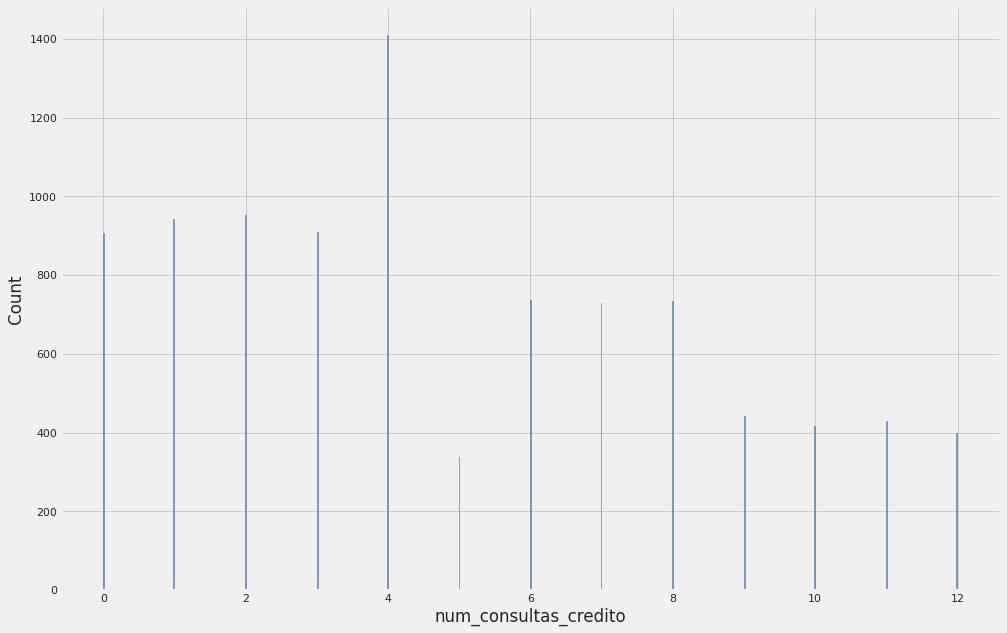

In [118]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['num_consultas_credito'] < 20, 'num_consultas_credito'], bins=500, kde=False);

In [119]:
df.loc[df['num_consultas_credito'] <= 10, 'num_consultas_credito'].median()

4.0

### TAXA_JUROS

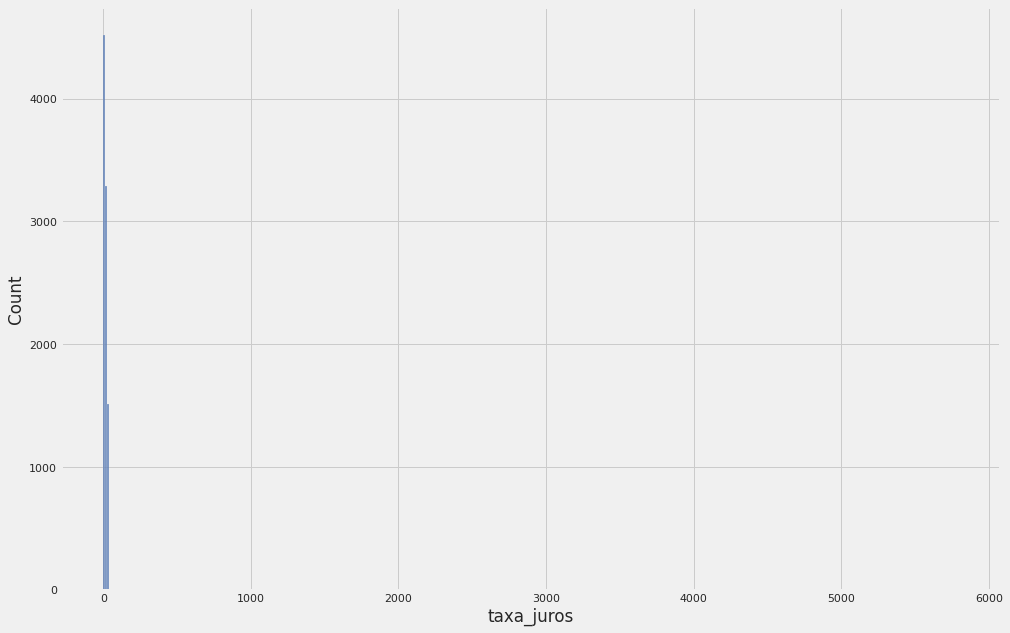

In [120]:
plt.figure(figsize=(15, 10))
sns.histplot(df['taxa_juros'], bins=500, kde=False);

In [121]:
df.loc[df['taxa_juros'] < 40, 'taxa_juros'].shape

(9325,)

In [122]:
df.loc[df['taxa_juros'] < 40, 'taxa_juros'].median()

13.0

In [334]:
df.loc[df['taxa_juros'] == 159, 'taxa_juros'].shape

(1,)

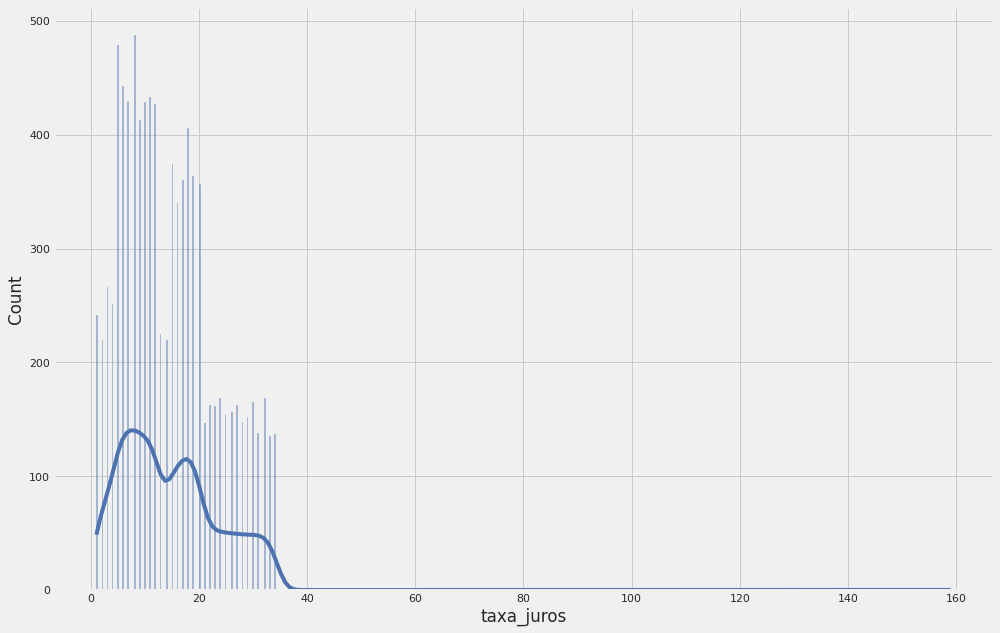

In [124]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['taxa_juros'] < 200, 'taxa_juros'], bins=500, kde=True);

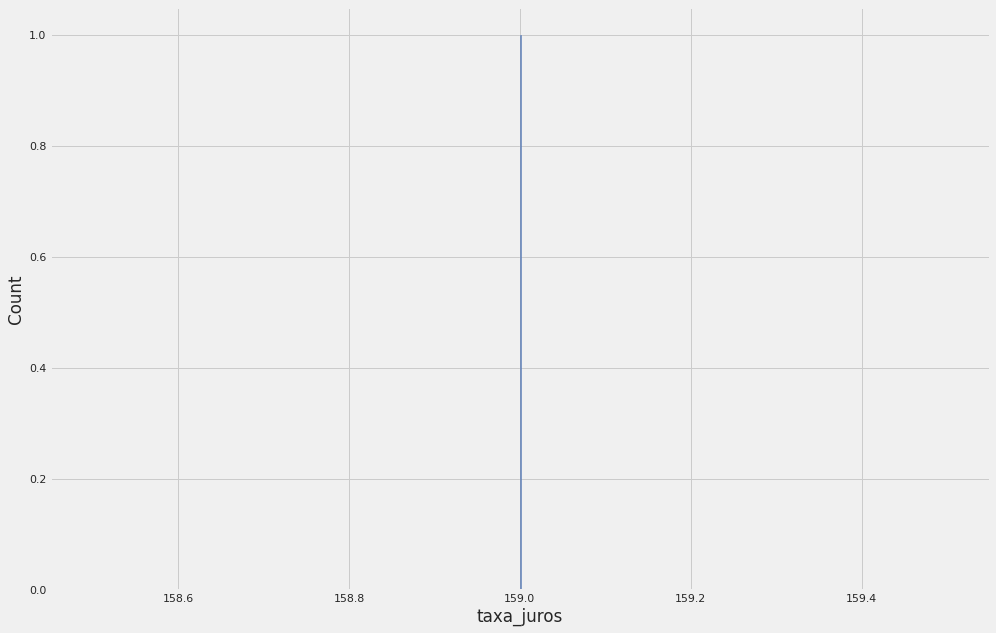

In [125]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[(df['taxa_juros'] > 150) & (df['taxa_juros'] < 200), 'taxa_juros'], bins=500, kde=False);

### IDADE

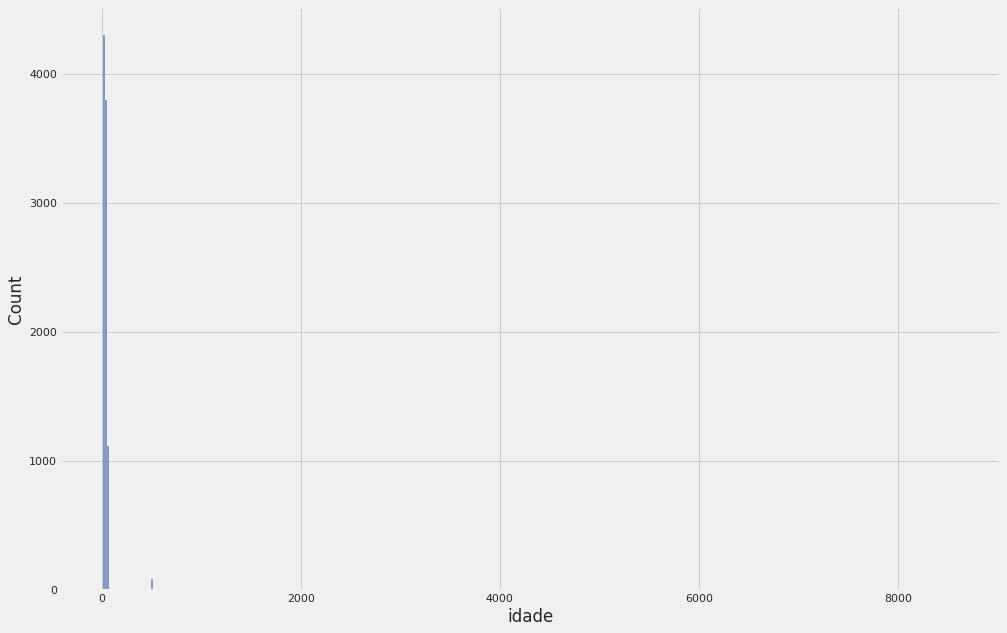

In [126]:
plt.figure(figsize=(15, 10))
sns.histplot(df['idade'], bins=500, kde=False);

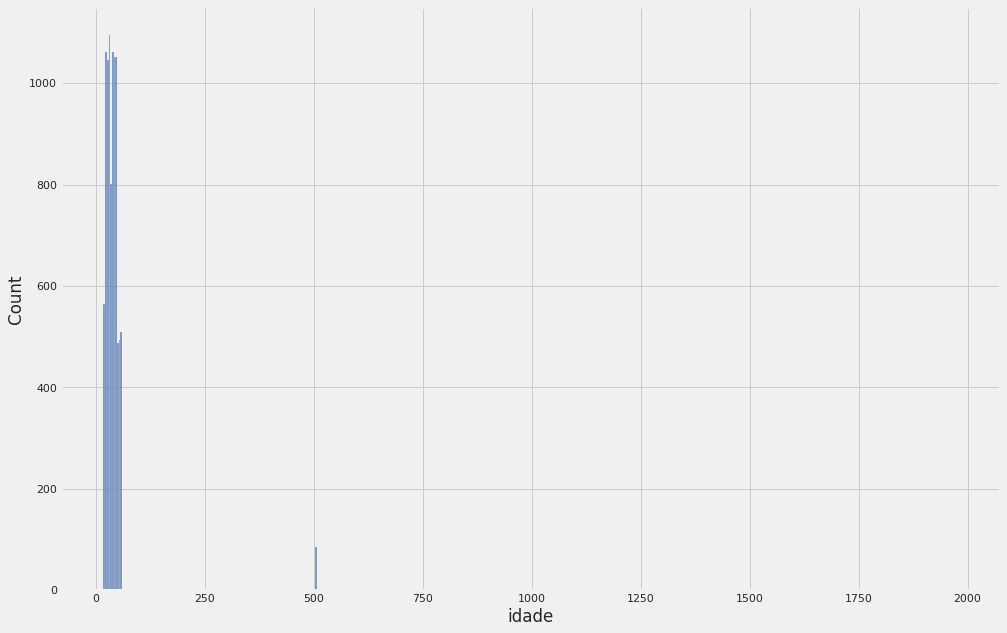

In [127]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[df['idade'] < 2000, 'idade'], bins=500, kde=False);

In [307]:
df.idade.max()

8598

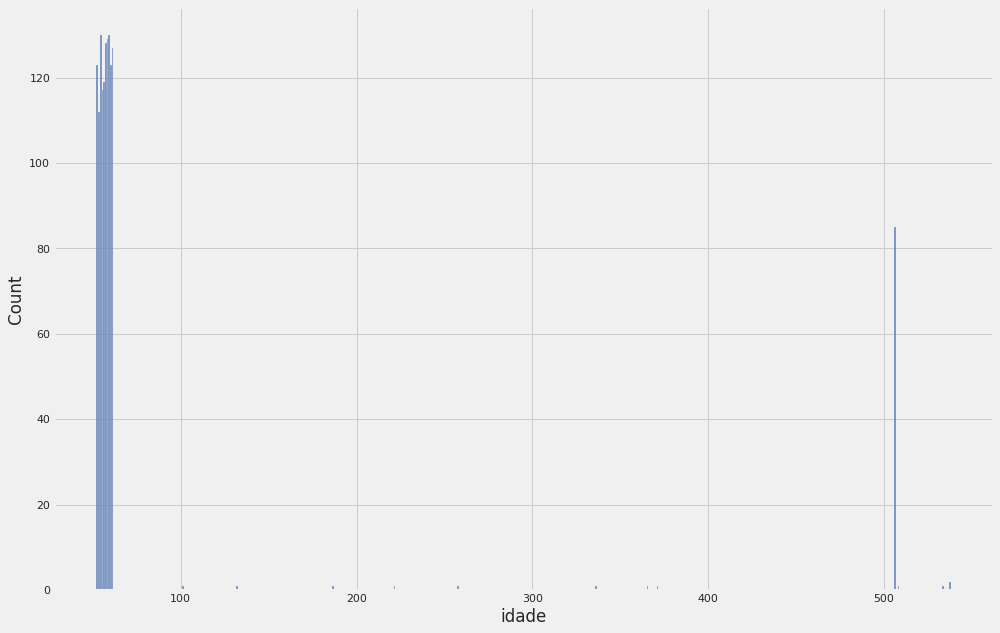

In [128]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[(df['idade'] > 50) & (df['idade'] < 550), 'idade'], bins=500, kde=False);

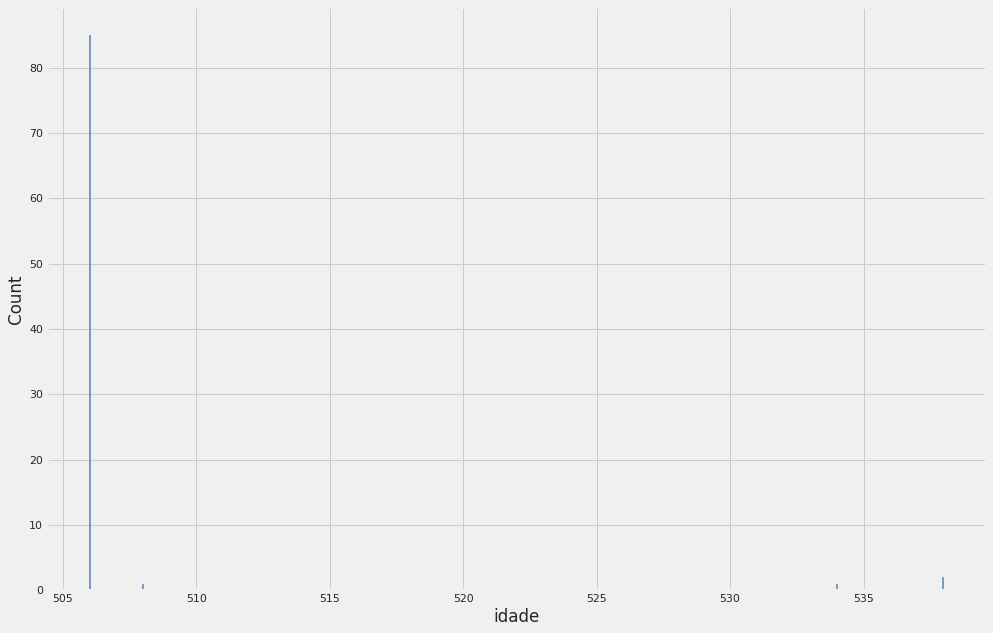

In [129]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[(df['idade'] > 500) & (df['idade'] < 550), 'idade'], bins=500, kde=False);

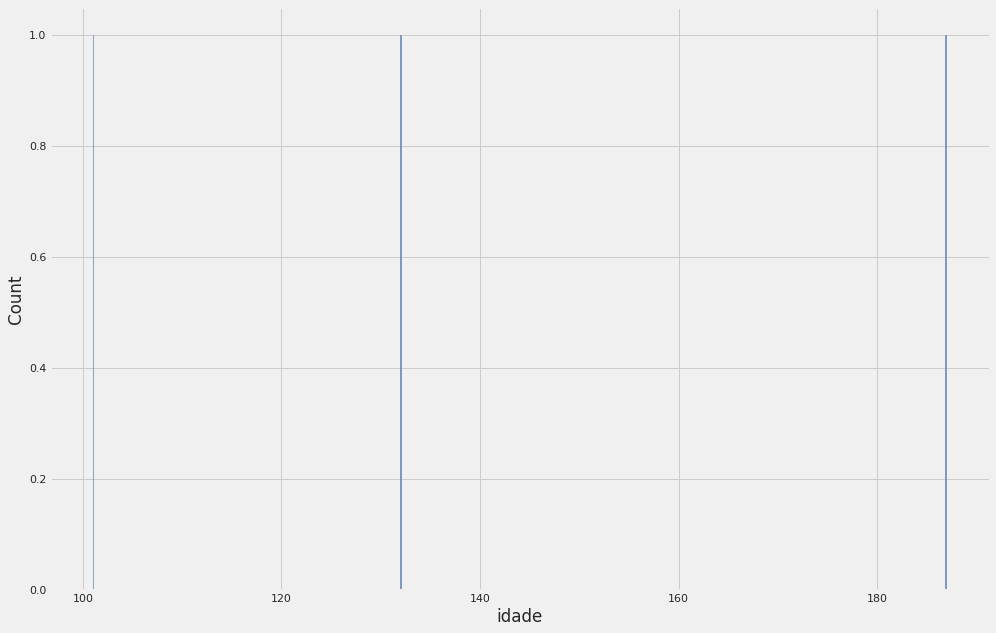

In [130]:
plt.figure(figsize=(15, 10))
sns.histplot(df.loc[(df['idade'] > 100) & (df['idade'] < 200), 'idade'], bins=500, kde=False);

In [131]:
df.loc[(df['idade'] > 100) & (df['idade'] < 200), 'idade']

2143    187
8909    101
9277    132
Name: idade, dtype: int64

In [132]:
df.loc[(df['idade'] > 100), 'idade'].shape

(280,)

In [134]:
df.loc[(df['idade'] < 101), 'idade'].median()

38.0

## Balance

In [136]:
df[['limite_adicional', 'id_cliente']].groupby('limite_adicional').agg({'id_cliente':'count'}).sort_values('limite_adicional', ascending=False)

balance = pd.DataFrame(data=df[['limite_adicional', 'id_cliente']].groupby('limite_adicional').agg({'id_cliente':'count'}).sort_values('limite_adicional', ascending=False), columns=['id_cliente'])
balance['Percent'] = balance['id_cliente'].apply(lambda x: '{:.2f}%'.format(float(x)/df.shape[0]*100))
balance = balance[balance['id_cliente'] > 0]
balance

,id_cliente,Percent
limite_adicional,,
Negar,7995,84.16%
Conceder,1505,15.84%


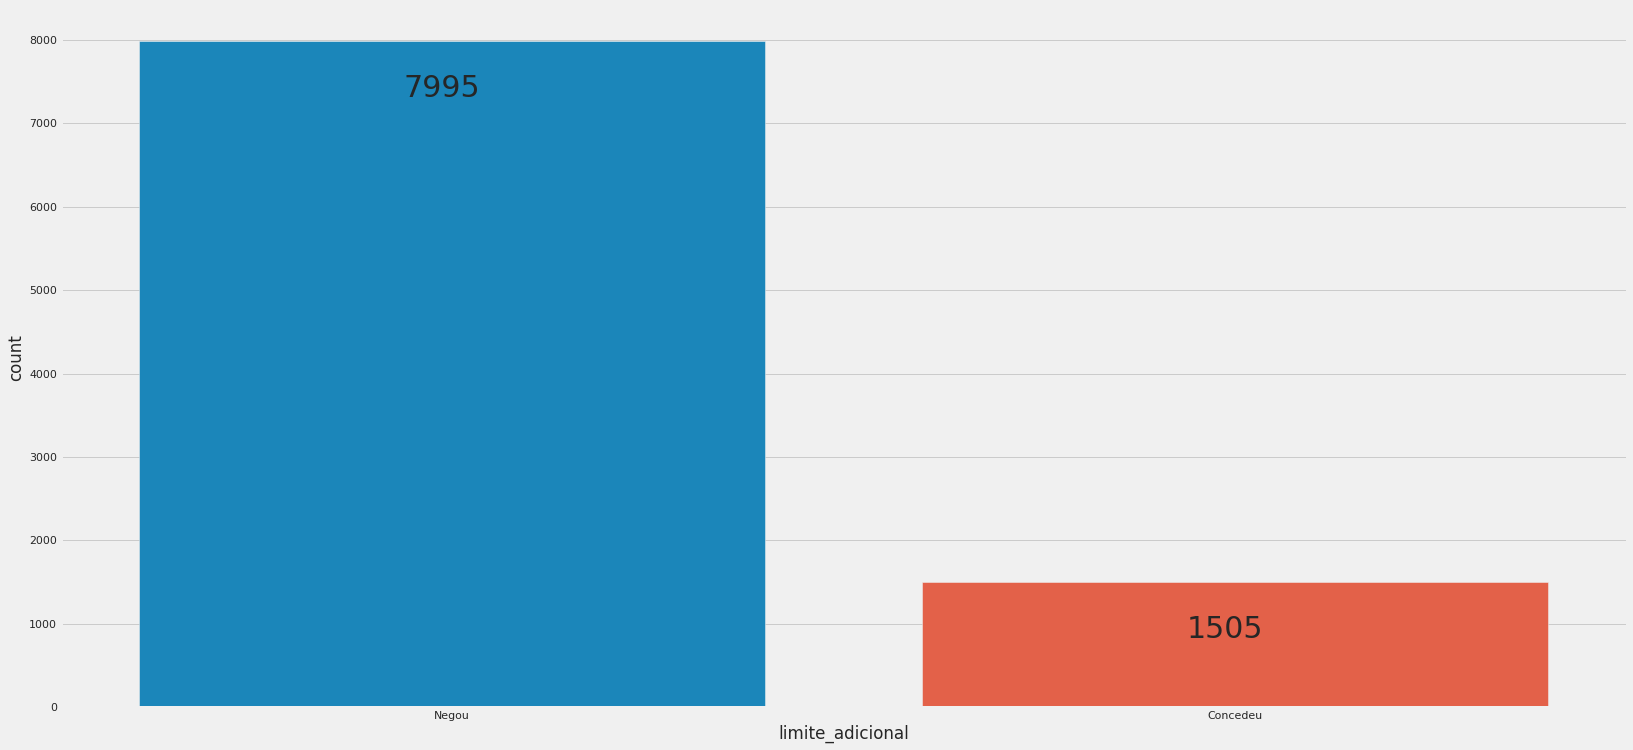

In [154]:
# visualize the target variable
g = sns.countplot(x=df['limite_adicional'])
g.set_xticklabels(['Negou','Concedeu'])
for p in g.patches:
    g.annotate('\n{:.0f}'.format(p.get_height()), (p.get_x()+0.387, p.get_height()), ha='center', va='top', size=30)
plt.show()

## Missing Values

In [137]:
df.isnull().sum()
miss_val = df.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=df.isnull().sum().sort_values(ascending=False), columns=['MissValCount'])
miss_val['Percent'] = miss_val['MissValCount'].apply(lambda x: '{:.2f}'.format(float(x)/df.shape[0]*100))
# miss_val.head()

In [138]:
miss_val

,MissValCount,Percent
id_cliente,0,0.00
num_cartoes_credito,0,0.00
pessoa_polit_exp,0,0.00
investe_exterior,0,0.00
taxa_juros,0,0.00
num_consultas_credito,0,0.00
num_pgtos_atrasados,0,0.00
dias_atraso_dt_venc,0,0.00
num_contas_bancarias,0,0.00
idade,0,0.00


## Correlation Heatmap

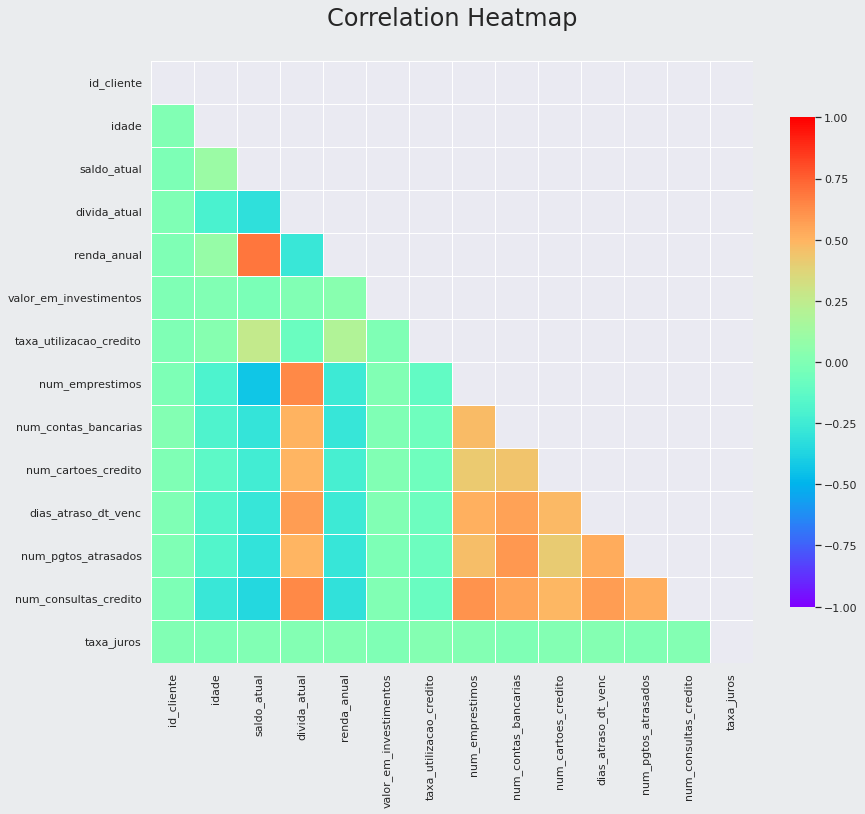

In [218]:
corr = data_filtered.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(12, 12), facecolor='#EAECEE')
cmap = sns.color_palette("rainbow", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1., center=0, annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.75})

ax.set_title('Correlation Heatmap', fontsize=24, y= 1.05)
colorbar = ax.collections[0].colorbar

- Podemos observar uma correlação significativa entre a variável 'dias_atraso' com 'dívida_atual'
- Saldo_atual também possui leve correlação com "taxa_utilização_credito"
- Temos que tratar os outliers para posterior analise de correlação.

## Bivariate Analysis which matters

In [164]:
bivar_data = df[(df['valor_em_investimentos'] != 10_000) & 
            (df['renda_anual'] < 200_000) & 
            (df['taxa_juros'] < 40) & 
            (df['num_consultas_credito'] < 12) & 
            (df['idade'] < 101) & 
            (df['num_cartoes_credito'] <= 11) & 
            (df['num_emprestimos'] < 28) & 
            (df['num_contas_bancarias'] < 11) & 
            (df['num_pgtos_atrasados'] < 30)]

In [165]:
bivar_data.shape

(7389, 17)

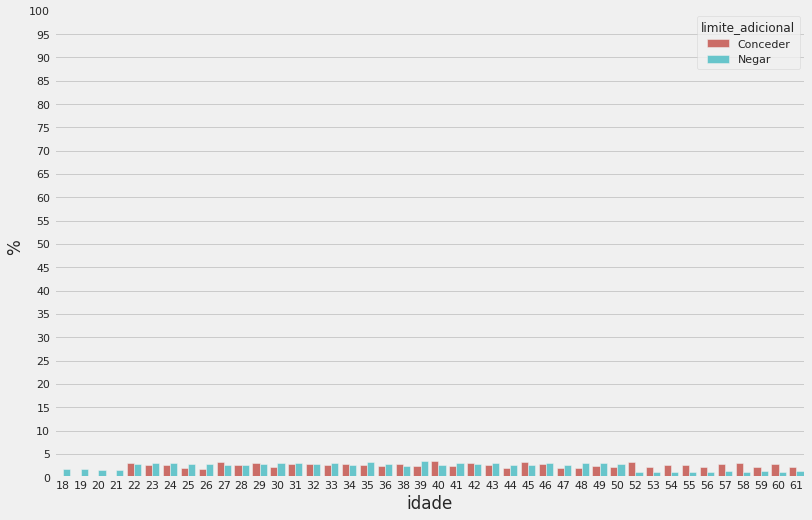

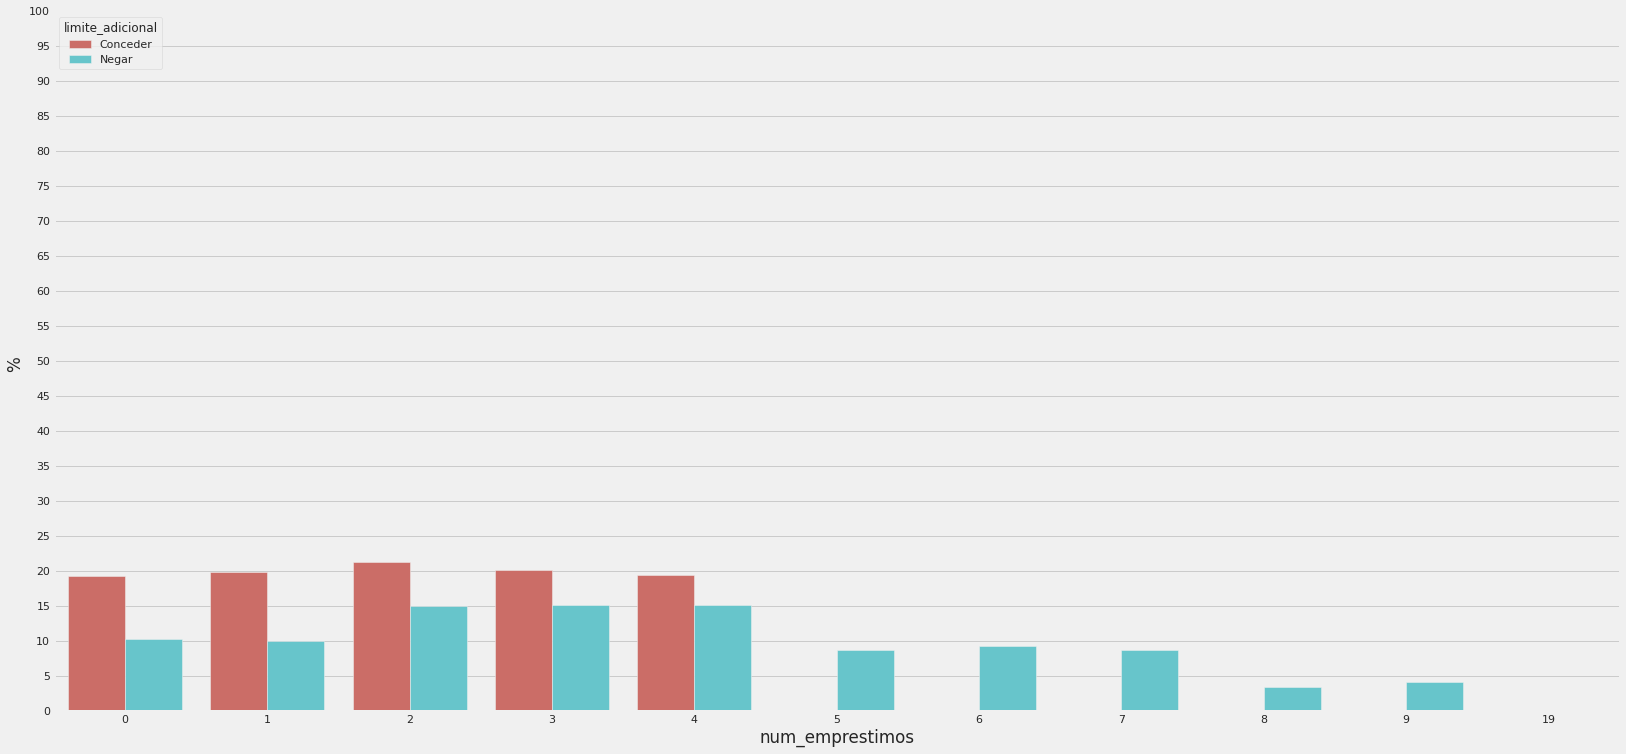

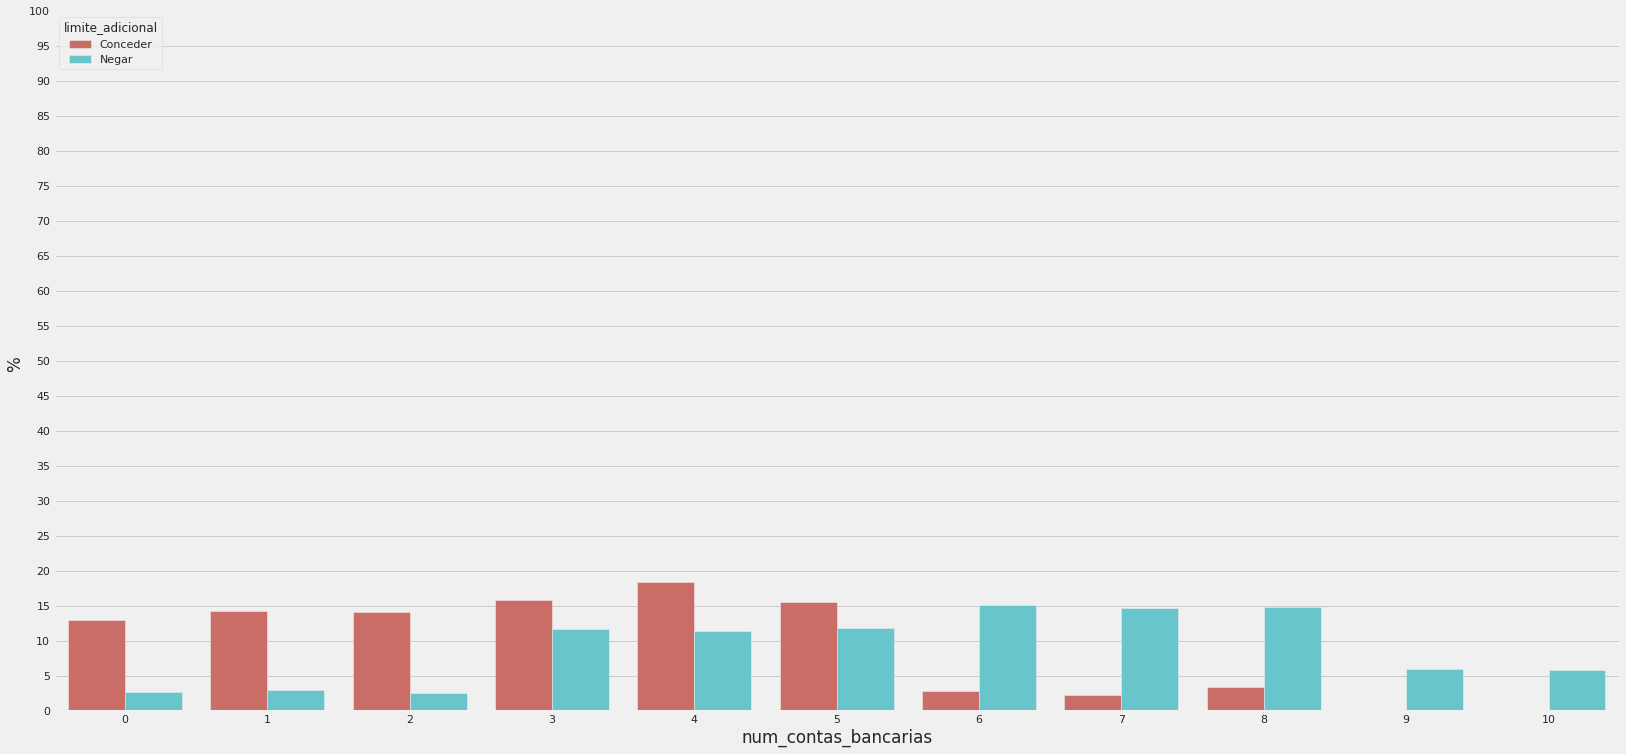

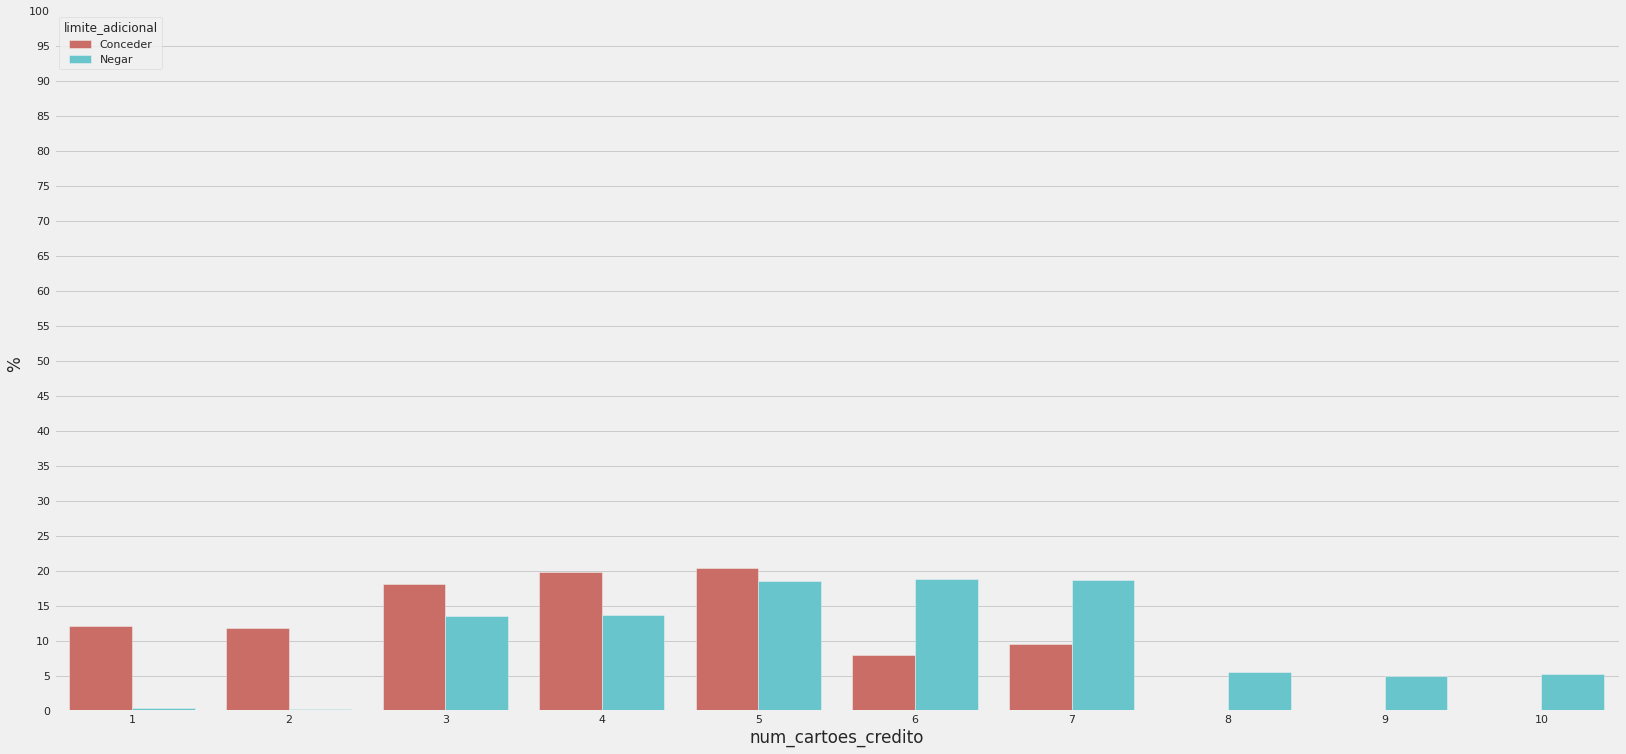

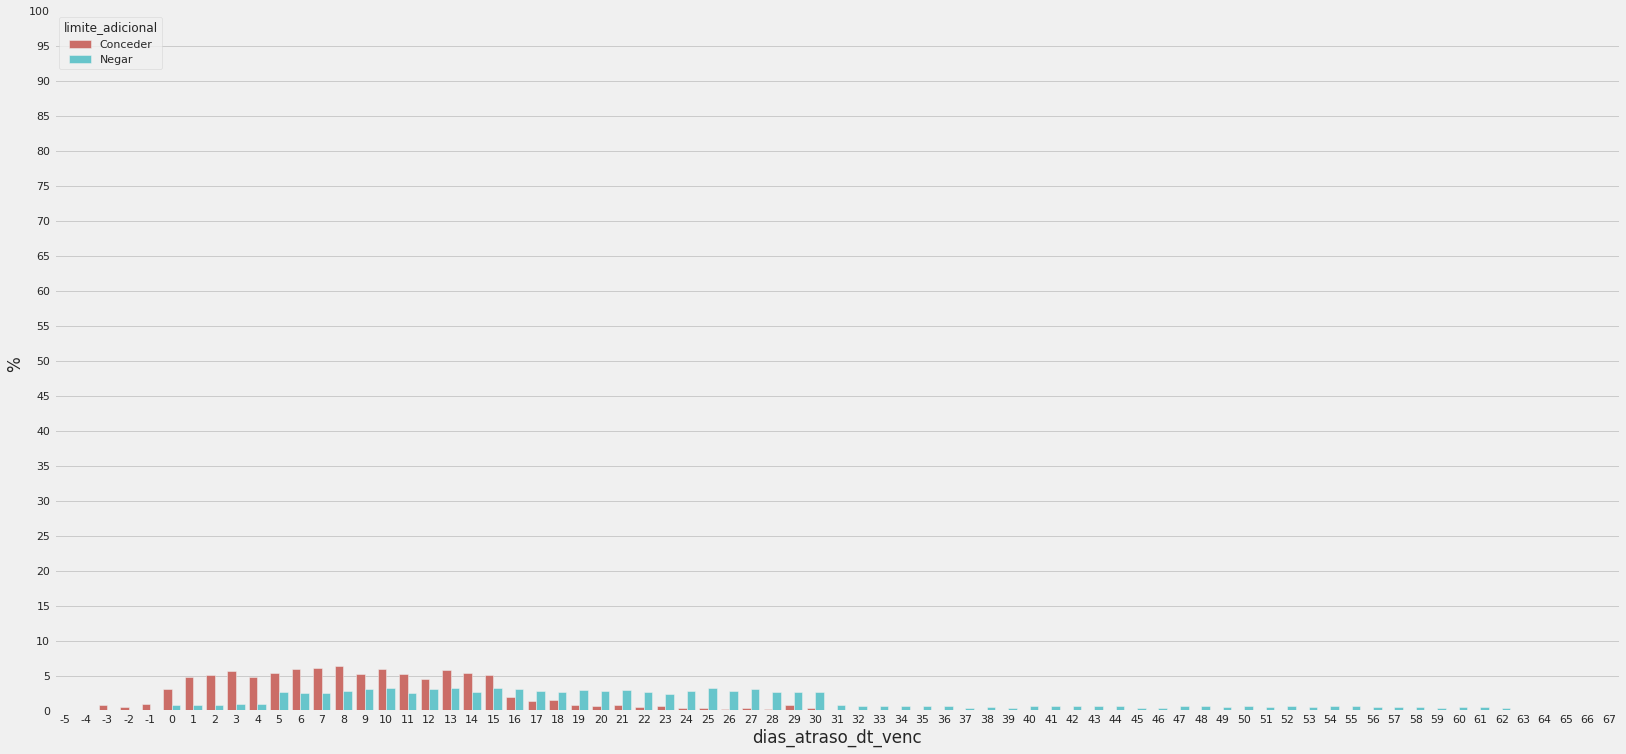

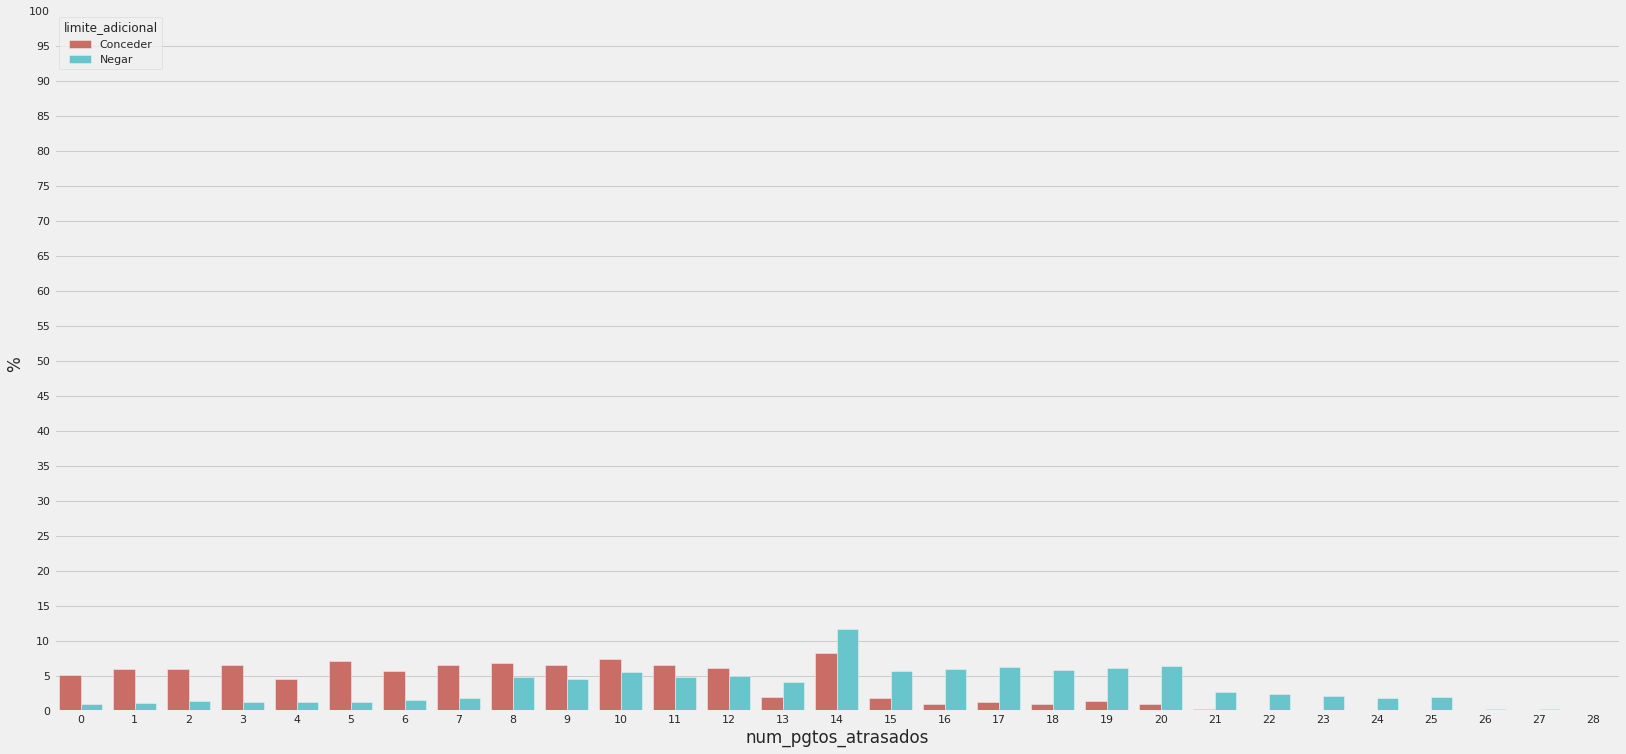

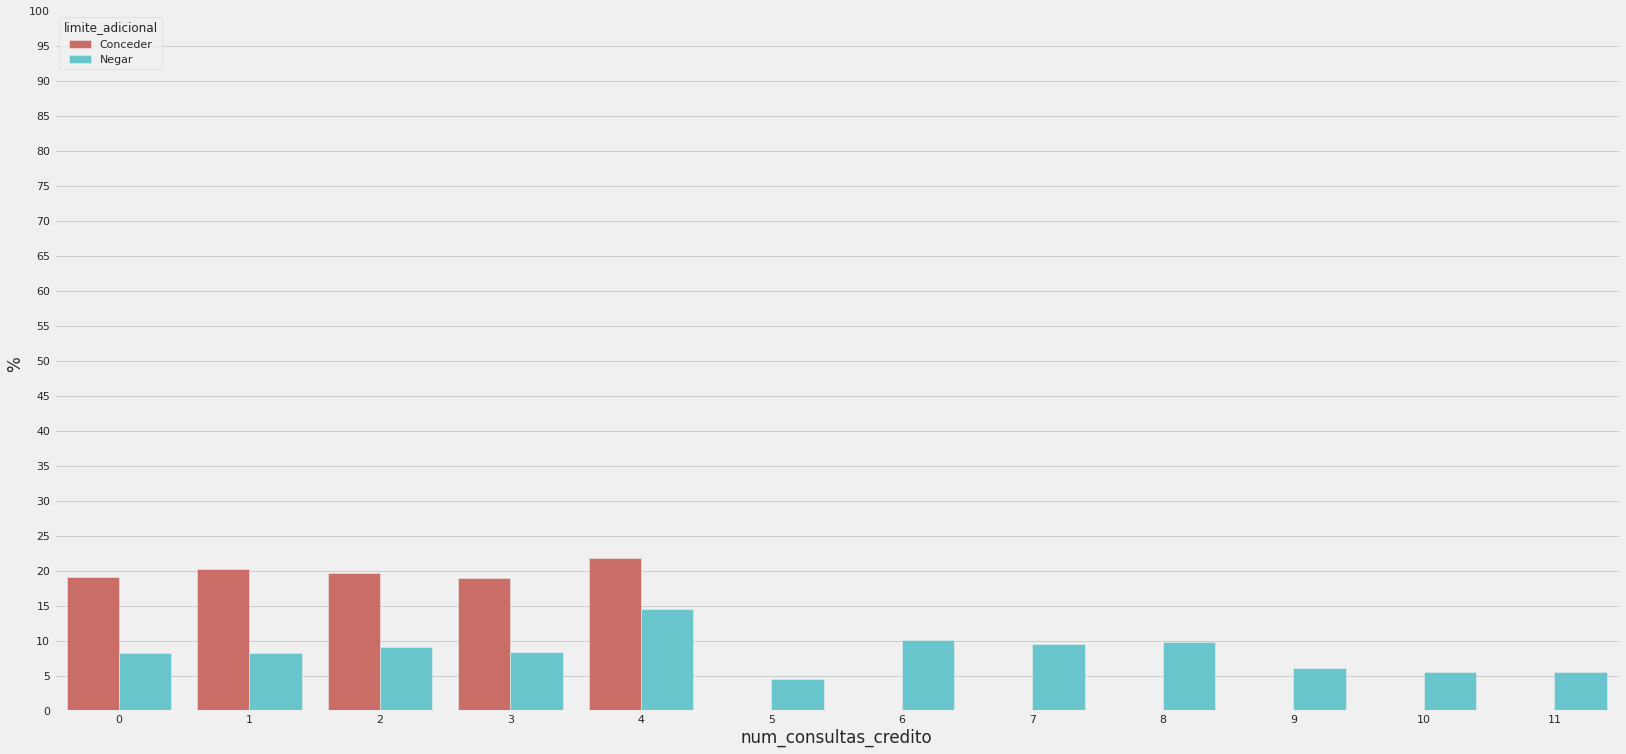

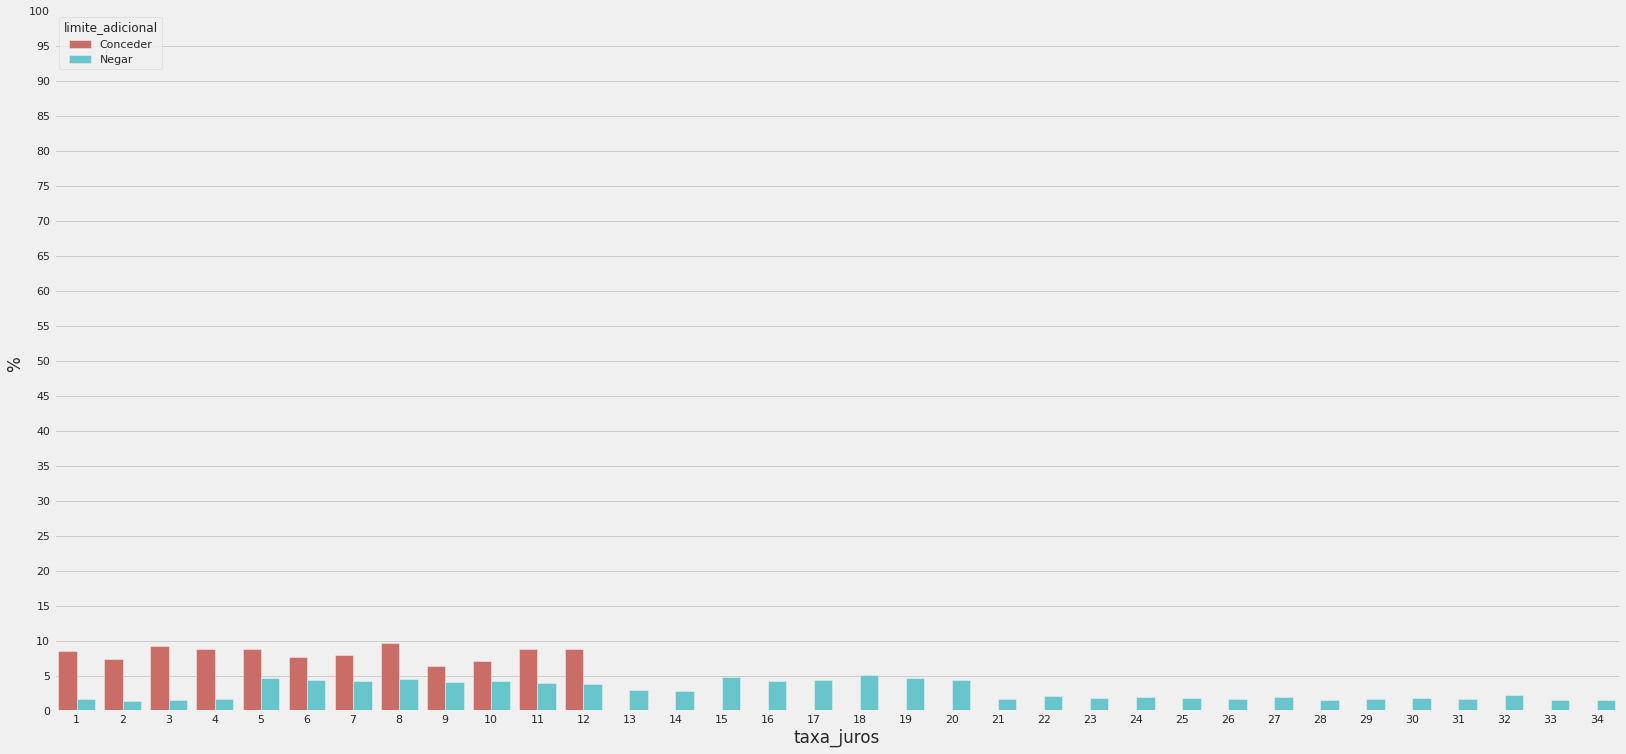

In [166]:
plt.figure(figsize=(12, 8))
for col in int_cols:
    plot_features(bivar_data, col, 'limite_adicional')

In [167]:
plt.figure(figsize=(12, 8))
for col in numerical_cols:
    plot_features(bivar_data, col, 'limite_adicional')

KeyboardInterrupt: 